# <span style="color:blue"> Binary Segmentation with the U-Net Model

**Segmenting a single object** - the ```Multiple Sclerosis``` dataset

In this notebook, we will train a U-Net model to perform semantic segmentation on RGB images of cars from the **Multiple Sclerosis dataset**. The objective of this task is to accurately separate the lesions from their background.

<span style="color:red"> **Before proceeding**, ensure the dataset is available at ```D:\PIR_SEP\Datasets\BRAIN_MRI_SLICES```  

<span style="color:black">

The **U-Net** architecture is ideal for this task because it combines a contracting path (encoder) and an expanding path (decoder). This design effectively captures both high-level global features and fine-grained local details.

This notebook will guide you through the following steps:
>1. **Imports:** Setting up required libraries and packages.
>2. **Data Loading and Visualization:** Understanding the dataset and preprocessing it for the task.
>3. **Network Architecture Definition:** Implementing the U-Net model.
>4. **Model Training:** Optimizing the network with backpropagation.
>5. **Inference and Evaluation:** Testing the model on unseen data and assessing its performance using relevant metrics.

---

### <span style="color:brown"> **What is Segmentation?**

Segmentation involves assigning a class label to every pixel in an image.

- **Binary Segmentation:** Identifies a single object class (e.g., car) against the background.
- **Multi-Class Segmentation:** Differentiates between multiple object classes.

---

### <span style="color:brown"> **Semantic vs. Instance Segmentation**

When multiple objects of the same class appear in an image:
- **Semantic Segmentation:** Assigns the same label to all objects of the same class.
- **Instance Segmentation:** Differentiates and labels each object instance separately, enabling object counting.

Instance separation can sometimes be performed using traditional image processing techniques after semantic segmentation.

<img src="figures/SemanticIntanceSegmentation.png" alt="Semantic vs Instance Segmentation" style="width: 75%;"/>

**In this notebook, we focus on semantic segmentation** using the U-Net deep learning architecture.

---

### <span style="color:brown"> **A Quick Overview of U-Net**

The U-Net architecture is a fully **convolutional network** designed for segmentation tasks. Its key features include:
- **Skip connections:** Directly link the encoder and decoder layers to preserve spatial details and scale information.
- **Symmetrical design:** Combines downsampling for context (**encoder in orange**) with upsampling for precise localization (**decoder in green**).

<img src="figures/UNet.png" alt="U-Net Architecture" style="width: 70%;"/>


## <span style="color:brown"> 1. Imports 
Before we begin, we will import the necessary libraries for data handling, image transformations, and model training using PyTorch.

In [133]:
# Import libraries
# PyTorch for building and training neural networks
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

from torch import Tensor

# Torchvision for data transformations
import torchvision
from torchvision import datasets, transforms

# Torchinfo to display model summaries
from torchinfo import summary

# Numpy and Pathlib for data handling
import numpy as np
from pathlib import Path

# Tqdm for progress bars
from tqdm.auto import tqdm

# Import the 'os' module, which provides functions for interacting with the operating system.
# This module is useful for tasks like handling file paths, creating directories, and managing files.
import os

# Import specific types from the 'typing' module, which provides support for type hints in Python.
# 'Optional' is used for indicating that a variable might be of a certain type or None.
# 'Union' allows a variable to be one of several types.
# 'Tuple' is used to specify a fixed-size sequence of elements of specified types.
from typing import Optional, Union, Tuple

# Monai for medical imaging, specific to preprocessing and loss functions
import monai
from monai.transforms import LoadImage
# from monai.losses import DiceLoss

# Matplotlib for data visualization
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

# Import the 'glob' module, which provides a way to retrieve files matching a specified pattern. 
# This is useful for loading multiple image and mask files from directories.
import glob
# Import the 'Image' class from the 'PIL' (Python Imaging Library) module.
# This class allows us to open, manipulate, and save various image file formats.
from PIL import Image

# Check and display library versions for reproducibility
print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"Numpy version: {np.__version__}")
print(f"Monai version: {monai.__version__}")

import copy
import os
import random
import shutil
import zipfile
from math import atan2, cos, sin, sqrt, pi, log

#import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
from numpy import linalg as LA
from torch import optim, nn
from torch.utils.data import DataLoader, random_split
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from tqdm import tqdm


PyTorch version: 2.6.0+cu118
Torchvision version: 0.21.0+cu118
Numpy version: 1.26.4
Monai version: 1.4.1rc1+46.gb58e883c


In [134]:

# Device setup
# Use GPU if available for faster training, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(torch.cuda.is_available())
print(torch.__version__)
print(torch.version.cuda)
print(torch.backends.cudnn.version())
!which python



Using device: cuda
True
2.6.0+cu118
11.8
90100
/c/Users/selkhalifi/.conda/envs/monai-dev/python


--- 
## <span style="color:brown"> 2. Load and Visualize the Data
In this section, we load and visualize RGB images from the carvana dataset.

Datasets often require preprocessing steps to prepare the data for training. Here, we will visualize a few examples to understand what our model will learn to segment. 
    

### <span style="color:brown"> 2.1 Create Dataset objects
`SepDataset`  will be used to load the data during training, validating and testing.

In [135]:
from torchvision import transforms
from PIL import Image
import torch
from torch.utils.data import Dataset

# Transformation personnalisée pour redimensionner l'image et le masque
class ResizeImageAndMask:
    def __init__(self, image_size, mask_size):
        #on redimensionne pour :
        #Uniformiser toutes les images (et masques) à une taille standard
        #Permettre des batchs (traiter plusieurs images à la fois)
        #Faire tourner le modèle sans crash
        
        #Quand tu redimensionnes une image, tu perds des pixels (ou tu en inventes, si tu agrandis).
        #→ L’interpolation est juste la méthode utilisée pour remplir les trous ou lisser la transition.

        # Redimensionner l'image avec interpolation bilinéaire, fait une moyenne des pixels voisins
        self.image_resize = transforms.Resize(image_size, interpolation=Image.BILINEAR)
        # Redimensionner le masque avec interpolation nearest (voisinage), plus proche voisin, si tu fais une interpolation bilinéaire, tu risques d’avoir des valeurs entre 0 et 1, genre 0.3, 0.8... ce qui n’a aucun sens pour un masque binaire
        self.mask_resize = transforms.Resize(mask_size, interpolation=Image.NEAREST)

    def __call__(self, sample):
        # Sample est un tuple (image, mask)
        image, mask = sample
        image = self.image_resize(image)
        mask = self.mask_resize(mask)
        return image, mask


class SepDataset(Dataset):
    #  def __init__(self, image_paths, mask_paths, resized_width, resized_height, limit=None):
    #limit = nombre limité de couples image/mask
    def __init__(self, root_path, resized_width, resized_height,limit=None):
        self.root_path = root_path
        self.limit = limit
        # Liste des chemins des images et des masques
        #trier les images et les masques (pour que image <-> mask reste aligné) et en prendre jusqu'à la limite définie
        self.images = sorted(
            [os.path.join(root_path, "train_data", i) 
             for i in os.listdir(os.path.join(root_path, "train_data")) 
             if i.endswith(".png")]
        )[:self.limit]
        
        self.masks = sorted(
            [os.path.join(root_path, "train_seg", i) 
             for i in os.listdir(os.path.join(root_path, "train_seg")) 
             if i.endswith(".png")]
        )[:self.limit]

        #définir la taille des images et des masques
        self.resized_width = resized_width
        self.resized_height = resized_height
        # Définir la transformation composée
        self.transform = transforms.Compose([
             ResizeImageAndMask((resized_width, resized_height), (resized_width, resized_height)),  # Redimensionner l'image et le masque
 
        ])

        if self.limit is None:
            self.limit = len(self.images)

    def __getitem__(self, index):
        # Charger l'image et le masque
        img = Image.open(self.images[index]).convert("L")
        mask = Image.open(self.masks[index]).convert("L") #luminance = noir et blanc

        # Appliquer la transformation composée (l'image et le masque doivent être passés comme un tuple)
        img, mask = self.transform((img, mask))  # Passer le tuple à la transformation

        # Convertir l'image en tenseur
        img = transforms.ToTensor()(img)

        # Vérifier la valeur maximale de l'image après la conversion en tenseur
        if img.max() > 1.0:  # Si l'image est dans la plage [0, 255]
            img = img / 255.0  # Normaliser les pixels dans la plage [0, 1]

        # Normalisation de l'image entre [-1, 1]
        img = (img - 0.5) / 0.5  # Normalisation de l'image

        # Convertir le masque en tenseur et binariser
        mask = transforms.ToTensor()(mask)  # Convertir le masque en tenseur
        mask = (mask > 0).float()  # Binariser le masque (0 ou 1)

        # Retourner l'image transformée, le masque transformé et le chemin de l'image
        return img, mask, self.images[index]

    def __len__(self):
        return min(len(self.images), self.limit)


### <span style="color:brown"> 2.2 - Load Files and Create Datasets

The ```SepDataset``` class is responsible for loading and formatting the data. It ensures that:
- The **size** of the images and masks (labels) is adjusted to the desired dimensions using resizing transformations.
- The **range** of pixel values is normalized:
  - **Images:** Normalized to the range [-1, 1] after being scaled to [0, 1].
  - **Masks:** Binarized to contain only 0 or 1 values after conversion to tensors.
- The **type** of images and masks is compatible with PyTorch:
  - Images are converted to `float32` tensors.
  - Masks are also converted to `float32` tensors but remain binary.

#### Using the Entire Dataset
To process the entire dataset, simply **omit the `limit` parameter** when calling the ```SepDataset``` class. If a value is provided for `limit`, only the specified number of samples will be loaded, which can be useful for debugging or testing.

```python
dataset = SepDataset(root_path="D:\PIR_SEP\Datasets\BRAIN_MRI_SLICES", resized_width=128, resized_height=128, limit=None)


In [136]:
from torch.utils.data import Dataset
from PIL import Image
import os
import torchvision.transforms as T

width=256   # width of images/masks processed by the network
height=336  # height of images/masks processed by the network
#print(os.listdir("./."))

root_dir = r"\\ps-home.insa-lyon.fr\users\home\selkhalifi\Documents\PIR\data2"

def dataset_axis(root_dir, axis, transform=None):
    """
    root_dir : dossier racine contenant 'axial', 'coronal', 'sagittal'
    axis : l'axe à charger
    transform : transformations à appliquer aux images et masques
    """
    
     # On trouve les images et les masques:
    train_dir = os.path.join(root_dir, axis)
    train_dataset = SepDataset(train_dir,resized_width=width,resized_height=height)        # Full database
    
    #Si tu n'utilisais pas de générateur, la division serait différente à chaque exécution du code.
    generator = torch.Generator().manual_seed(25)

    #diviser le dataset en dataset d'entraînement et de test de manière random avec 0.8 train et 0.2 test en utilisant les générateur
    train_dataset, test_dataset = random_split(train_dataset, [0.8, 0.2], generator=generator)
    print("Size dataset :",len(train_dataset)+len(test_dataset))
    print("Size train_dataset :",len(train_dataset))
    print("Size test_dataset :",len(test_dataset))
    
    #diviser le dataset de test en dataset de test et de validation à 0.5 et 0.5 en utilisant le générateur
    test_dataset, val_dataset = random_split(test_dataset, [0.5, 0.5], generator=generator)
    print("Size train_dataset :",len(train_dataset))
    print("Size test_dataset :", len(test_dataset))
    print("Size val_dataset :", len(val_dataset))

    return train_dataset, val_dataset, test_dataset

# Stocker les données de chaque axe dans un dictionnaire
# On stocke les datasets dans un dictionnaire
all_datasets = {}
for axis in ["red", "green", "yellow"]:
    train_set, test_set, val_set = dataset_axis(root_dir, axis)
    all_datasets[axis] = {"train": train_set, "test": test_set, "val": val_set}

device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    num_workers = torch.cuda.device_count() * 4 - 1 #L'idée de multiplier par 4 et soustraire 1 est une méthode pour utiliser efficacement les ressources disponibles.
#num_workers = 1  # cmu
print("device :",device)
print("num_workers :",num_workers)

LEARNING_RATE = 3e-4 #Le learning rate (taux d'apprentissage) détermine à quel point les poids du modèle doivent être ajustés pendant l'entraînement à chaque itération.
BATCH_SIZE = 8  # 1   #  4, 8, 16, 32 Le batch size (taille du lot) détermine combien d'exemples seront traités simultanément dans chaque passage du modèle pendant l'entraînement.


Size dataset : 15
Size train_dataset : 12
Size test_dataset : 3
Size train_dataset : 12
Size test_dataset : 2
Size val_dataset : 1
Size dataset : 15
Size train_dataset : 12
Size test_dataset : 3
Size train_dataset : 12
Size test_dataset : 2
Size val_dataset : 1
Size dataset : 15
Size train_dataset : 12
Size test_dataset : 3
Size train_dataset : 12
Size test_dataset : 2
Size val_dataset : 1
device : cuda
num_workers : 3


In [137]:
# Charger les datasets pour un axe donné (ex. red)
train_dataset, val_dataset, test_dataset = dataset_axis(root_dir, "red")

#Création des objets DataLoader pour charger les données d'entraînement, de validation et de test dans des mini-lots (batches) pendant l'entraînement de ton modèle.
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True) #Cela signifie que les données seront mélangées à chaque époque pour éviter que le modèle apprenne de manière séquentielle et n'intègre pas des biais liés à l'ordre des données.
val_dataloader = DataLoader(dataset=val_dataset,batch_size=BATCH_SIZE,shuffle= False) #Les données de validation ne sont pas mélangées. Cela permet de toujours tester le modèle sur les mêmes données à chaque époque pour une évaluation stable.
test_dataloader = DataLoader(dataset=test_dataset,batch_size=BATCH_SIZE, shuffle=False) #Comme pour la validation, les données de test ne sont pas mélangées pour garantir une évaluation cohérente.

Size dataset : 15
Size train_dataset : 12
Size test_dataset : 3
Size train_dataset : 12
Size test_dataset : 2
Size val_dataset : 1


In [138]:
# Vérification du DataLoader
for img, mask, path in  test_dataloader:
    print(f'Image batch shape: {img.shape}') #nbre d'images dans le batch, nombre de canaux (3 pour RGB, 1 pour L), hauteur, largeur)
    print(f'Mask batch shape: {mask.shape}')
    print(f'Image path: {path[0]}')  # Afficher un chemin d'image pour vérifier
    break  # Juste pour vérifier une première itération


Image batch shape: torch.Size([2, 1, 256, 336])
Mask batch shape: torch.Size([2, 1, 256, 336])
Image path: \\ps-home.insa-lyon.fr\users\home\selkhalifi\Documents\PIR\data2\red\train_data\07010NABO_3DFLAIR.png


In [139]:
for axis in ["red", "green", "yellow"]:
    print(f"\n Axe : {axis.upper()}")
    
    # Récupérer le dataloader de test correspondant
    test_dataset = all_datasets[axis]["test"]
    test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    
    # Créer un itérateur
    test_dataloader_iter = iter(test_dataloader)
    
    # Prendre un batch
    batch_data = next(test_dataloader_iter)
    image, label = batch_data[0].to(device), batch_data[1].to(device)
    
    # Afficher infos
    print("image.shape :", image.shape)
    print("label.shape :", label.shape)
    print("torch.max(label) :", torch.max(label))
    print("torch.max(image) :", torch.max(image))



 Axe : RED
image.shape : torch.Size([1, 1, 256, 336])
label.shape : torch.Size([1, 1, 256, 336])
torch.max(label) : tensor(0., device='cuda:0')
torch.max(image) : tensor(0.7333, device='cuda:0')

 Axe : GREEN
image.shape : torch.Size([1, 1, 256, 336])
label.shape : torch.Size([1, 1, 256, 336])
torch.max(label) : tensor(1., device='cuda:0')
torch.max(image) : tensor(0.9373, device='cuda:0')

 Axe : YELLOW
image.shape : torch.Size([1, 1, 256, 336])
label.shape : torch.Size([1, 1, 256, 336])
torch.max(label) : tensor(1., device='cuda:0')
torch.max(image) : tensor(0.9451, device='cuda:0')


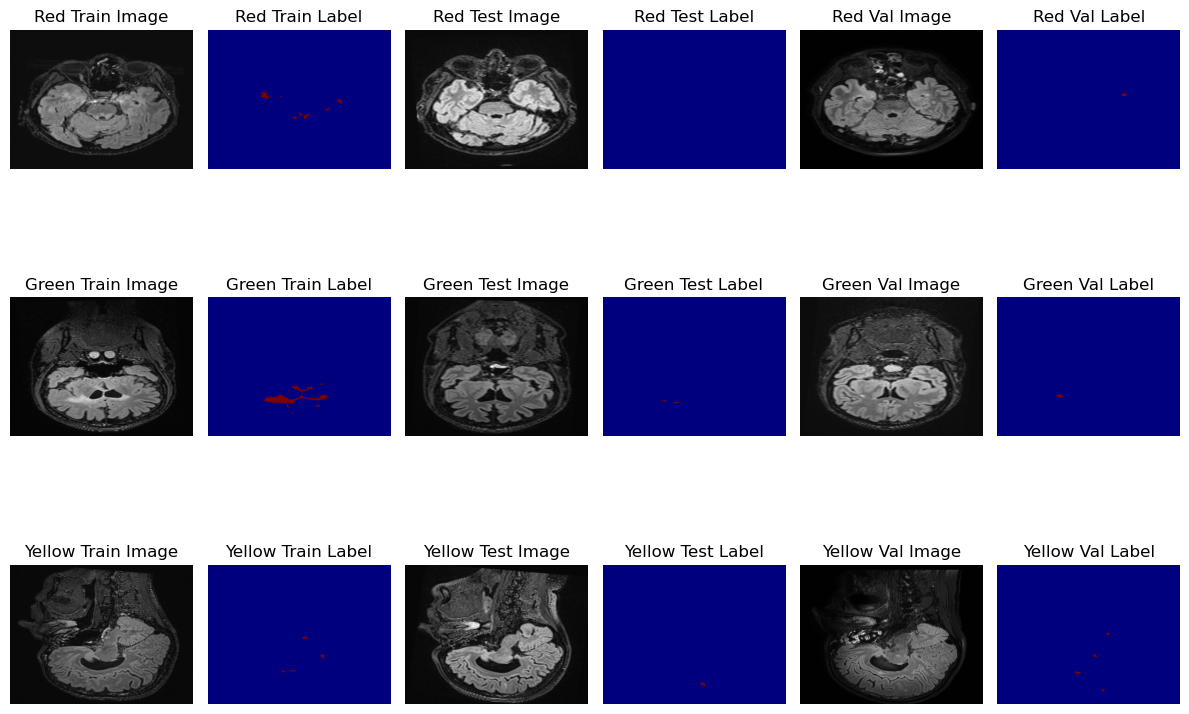

In [140]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# 🔍 Affichage
figure = plt.figure(figsize=(12, 9))

def display_image_and_label(image, label, index, title_prefix):
    image = image.detach().cpu().numpy()
    label = label.detach().cpu().numpy()
    image = np.squeeze(image)
    label = np.squeeze(label)
    
    ax_img = figure.add_subplot(3, 6, index * 2 + 1)
    ax_img.imshow(image, cmap="gray")
    ax_img.set_title(f"{title_prefix} Image")
    ax_img.axis("off")
    
    ax_mask = figure.add_subplot(3, 6, index * 2 + 2)
    ax_mask.imshow(label, cmap="jet", alpha=1)
    ax_mask.set_title(f"{title_prefix} Label")
    ax_mask.axis("off")

row_index = 0
for axis_name, splits in all_datasets.items():
    for split_name, dataset in splits.items():
        idx = np.random.randint(len(dataset))
        sample = dataset[idx]
        image = sample[0]
        label = sample[1]
        display_image_and_label(image, label, row_index, f"{axis_name.capitalize()} {split_name.capitalize()}")
        row_index += 1

plt.tight_layout()
plt.show()


---
## <span style="color:brown"> 3. Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)

The U-Net model for binary segmentation takes a batch of input images and processes each image to output **a corresponding probability map**. Each pixel in this map represents the likelihood that the pixel belongs to the target object class. 

Since we’re performing binary segmentation, the output for each image is a single-channel tensor, where each pixel value ranges between 0 and 1. A value closer to 1 indicates a higher probability that the pixel is part of the target object, while a value closer to 0 suggests background.

This approach allows the model to efficiently learn the spatial structure of the objects within the images, providing pixel-wise predictions for accurate segmentation.

### <span style="color:brown"> 3.1 Model Architecture Parameters

In [141]:
# Model Architecture Parameters
input_channels = 1    #e.g. 3 for RGB, 1 for grayscale input images
num_classes  = 1      #  e.g. 1 for binary segmentation (background vs object)
input_shape = (input_channels, width, height)  # This is the shape of the input image to the network
output_shape = (num_classes, width, height)  # This is the shape of the output mask
init_channels = 32              # This is the number of channels in the first layer of the network
# Nombre de filtres appliqués à l’image dans la 1ère couche
#Chaque filtre apprend à détecter quelque chose de différent :
#un peut détecter des bords horizontaux,
#un autre les coins,
#un autre une texture spécifique, etc.

### <span style="color:brown">3.2 Model Architecture</span>

In this section, two distinct model architectures are provided. However, you should only use one model for your task. Please select and activate the corresponding cell below based on your preferred model choice.

#### <span style="color:brown">Comparison of MONAI's `UNet` and Custom `UNet` Model in PyTorch</span>

When working with U-Net architectures for image segmentation, both **MONAI**'s `UNet` and a **custom PyTorch U-Net** can be used. However, they offer different levels of abstraction, flexibility, and usability. Below is a comparison of these two approaches:



##### <span style="color:brown">MONAI `UNet` Model</span> (from `monai.networks.nets`)

- **Purpose**: MONAI is a framework specifically designed for medical imaging tasks, built on top of PyTorch.
  
- **Ease of Use**: MONAI provides a high-level interface that simplifies the process of creating U-Net models. It allows users to quickly configure and instantiate a U-Net model by specifying only a few parameters, such as the number of input and output channels, the number of feature channels, and other configuration parameters like the stride and number of residual units.

- **Customizability**: While MONAI's `UNet` is highly configurable with parameters like `channels`, `strides`, and `num_res_units`, it hides some of the underlying complexity of U-Net, making it suitable for users who want an easy-to-implement model. 

- **Key Features**:
  - Optimized for 2D and 3D medical image segmentation.
  - Predefined configurations for common tasks, reducing setup time.
  - Focus on usability for medical AI tasks.


##### <span style="color:brown">Custom U-Net Model in PyTorch</span>

- **Purpose**: A custom U-Net implementation in PyTorch provides full flexibility, allowing users to define the architecture according to their specific needs. This model can be used for both general and specialized image segmentation tasks, not just medical imaging.

- **Flexibility**: The custom implementation allows for fine-grained control over every aspect of the network architecture. You can modify the number of layers, types of layers, normalization methods, upsampling techniques, and more.

- **Complexity**: Writing a custom U-Net requires more effort as you must manually define each block (e.g., convolution layers, downsampling, and upsampling). This gives more control over the implementation but increases the amount of code and complexity.

- **Customizability**: You can adjust various hyperparameters, such as the type of convolution (`Conv2d` or `ConvTranspose2d`), batch normalization, dropout rates, and even the use of bilinear interpolation or transposed convolutions for upsampling.

- **Key Features**:
  - Full control over architecture.
  - Greater flexibility to modify layer types and network structure.
  - Ideal for users who need customization for specific segmentation tasks.



##### <span style="color:brown">Comparison Table</span>

| **Feature**                        | **MONAI `UNet`**                                  | **Custom PyTorch `UNet`**                      |
|------------------------------------|--------------------------------------------------|-----------------------------------------------|
| **Ease of Use**                    | High (dedicated for medical image segmentation)   | Low (manual implementation required)          |
| **Flexibility**                    | Moderate (configurable parameters)               | High (full control over architecture)         |
| **Customizability**                | Low (limited to predefined blocks and parameters) | High (customize every part of the network)     |
| **Code Complexity**                | Low (simple instantiation)                       | High (requires manual architecture design)    |
| **Intended Use Case**              | Medical imaging segmentation                     | General segmentation tasks                    |


### <span style="color:brown"> Model Architecture: Custom Unet 

In [142]:
class UNet(nn.Module):
    """Architecture based on U-Net: Convolutional Networks for Biomedical Image Segmentation.

    References:
    - Paper that introduced the U-Net model: https://arxiv.org/abs/1505.04597
    """

    def __init__(
        self,
        input_shape: Tuple[int, ...],
        output_shape: Tuple[int, ...],
        init_channels: int = 32,
        use_batchnorm: bool = True,
        bilinear: bool = False,
        dropout: float = 0.0,
    ):
        """Initializes class instance.

        Args:
            input_shape: (in_channels, H, W), Shape of the input images.
            output_shape: (num_classes, H, W), Shape of the output segmentation map.
            init_channels: Number of output feature maps from the first layer, used to compute the number of feature
                maps in following layers.
            use_batchnorm: Whether to use batch normalization between the convolution and activation layers in the
                convolutional blocks.
            bilinear: Whether to use bilinear interpolation or transposed convolutions for upsampling.
            dropout: Probability of an element to be zeroed (e.g. 0 means no dropout).
        """
        super().__init__()
        in_channels = input_shape[0]
        out_channels = output_shape[0]

        self.layer1 = _DoubleConv(in_channels, init_channels // 2, dropout / 2, use_batchnorm)
        self.layer2 = _Down(init_channels // 2, init_channels, dropout, use_batchnorm)
        self.layer3 = _Down(init_channels, init_channels * 2, dropout, use_batchnorm)
        self.layer4 = _Down(init_channels * 2, init_channels * 4, dropout, use_batchnorm)

        self.layer5 = _Up(
            init_channels * 4, init_channels * 2, dropout, use_batchnorm, bilinear=bilinear
        )
        self.layer6 = _Up(
            init_channels * 2, init_channels, dropout, use_batchnorm, bilinear=bilinear
        )
        self.layer7 = _Up(init_channels, init_channels // 2, 0, use_batchnorm, bilinear=bilinear)

        self.layer9 = nn.Conv2d(init_channels // 2, out_channels, kernel_size=1)

        # Use Xavier initialisation for weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.xavier_uniform_(m.weight)

    def forward(self, x: Tensor) -> Tensor:
        """Defines the computation performed at every call.

        Args:
            x: (N, ``in_channels``, H, W), Input image to segment.

        Returns:
            (N, ``out_channels``, H, W), Raw, unnormalized scores for each class in the input's segmentation.
        """
        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)

        out = self.layer5(x4, x3)
        out = self.layer6(out, x2)
        out = self.layer7(out, x1)

        return self.layer9(out)


class _DoubleConv(nn.Module):
    """Double Convolution and BN and ReLU.

    (3x3 conv -> BN -> ReLU) ** 2
    """

    def __init__(self, in_ch: int, out_ch: int, dropout_prob: float, use_batchnorm: bool):
        super().__init__()
        if use_batchnorm:
            self.net = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.Dropout(p=dropout_prob),
                nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.Dropout(p=dropout_prob),
            )
        else:
            self.net = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Dropout(p=dropout_prob),
                nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Dropout(p=dropout_prob),
            )

    def forward(self, x: Tensor) -> Tensor:
        return self.net(x)


class _Down(nn.Module):
    """Combination of MaxPool2d and DoubleConv in series."""

    def __init__(self, in_ch: int, out_ch: int, dropout_prob: float, use_batchnorm: bool):
        super().__init__()
        self.net = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            _DoubleConv(in_ch, out_ch, dropout_prob, use_batchnorm),
        )

    def forward(self, x: Tensor) -> Tensor:  
        return self.net(x)


class _Up(nn.Module):
    """Upsampling (by either bilinear interpolation or transpose convolutions).

    followed by concatenation of feature map from contracting path, followed by double 3x3
    convolution.
    """

    def __init__(
        self, in_ch, out_ch: int, dropout_prob: float, use_batchnorm: bool, bilinear: bool = False
    ):
        super().__init__()
        self.upsample = None
        if bilinear:
            self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        else:
            self.upsample = nn.ConvTranspose2d(in_ch, in_ch // 2, kernel_size=2, stride=2)

        self.conv = _DoubleConv(in_ch, out_ch, dropout_prob, use_batchnorm)

    def forward(self, x: Tensor, connected_encoder_features: Tensor) -> Tensor:
        x = self.upsample(x)

        # Pad ``x`` to the size of ``connected_encoder_features``
        diff_h = connected_encoder_features.shape[2] - x.shape[2]
        diff_w = connected_encoder_features.shape[3] - x.shape[3]

        x = F.pad(x, [diff_w // 2, diff_w - diff_w // 2, diff_h // 2, diff_h - diff_h // 2])

        # Concatenate along the channels axis
        x = torch.cat([connected_encoder_features, x], dim=1)

        return self.conv(x)


# initialize the NN
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(input_shape=input_shape, output_shape=output_shape, init_channels=init_channels).to(device)

### <span style="color:brown"> Function: ```Summary``` </span>

The **summary** function provides a detailed overview of the model. Pay close attention to the following key information:

- **Number of parameters**: This indicates the total number of learnable parameters in the model, which can give you insight into its complexity.
- **Total model size**: This refers to the overall size of the model in memory, which is important for assessing its computational requirements and suitability for deployment.

Understanding these details can help you evaluate the efficiency and scalability of the model.

In [143]:
# Print the summary of the network
#summary_kwargs:	Un dictionnaire de paramètres pour summary()
summary_kwargs = dict(
    col_names=["input_size", "output_size", "kernel_size", "num_params"], depth=5, verbose=0
)
#verbose=0	N’affiche pas les entrées/sorties des modules très petits ou inutiles (plus clean)
#summary(model, input_size = (32,3, 64, 64),  device=device, **summary_kwargs)
summary(model, input_size = (BATCH_SIZE,1, width, height),  device=device, **summary_kwargs)
#**summary_kwargs: Tu le "déplies" pour passer chaque clé/valeur comme un argument à la fonction

Layer (type:depth-idx)                        Input Shape               Output Shape              Kernel Shape              Param #
UNet                                          [8, 1, 256, 336]          [8, 1, 256, 336]          --                        --
├─_DoubleConv: 1-1                            [8, 1, 256, 336]          [8, 16, 256, 336]         --                        --
│    └─Sequential: 2-1                        [8, 1, 256, 336]          [8, 16, 256, 336]         --                        --
│    │    └─Conv2d: 3-1                       [8, 1, 256, 336]          [8, 16, 256, 336]         [3, 3]                    160
│    │    └─BatchNorm2d: 3-2                  [8, 16, 256, 336]         [8, 16, 256, 336]         --                        32
│    │    └─ReLU: 3-3                         [8, 16, 256, 336]         [8, 16, 256, 336]         --                        --
│    │    └─Dropout: 3-4                      [8, 16, 256, 336]         [8, 16, 256, 336]         --     

In [144]:
# Print the summary of the network
summary_kwargs = dict(
    col_names=["input_size", "output_size", "kernel_size", "num_params"], depth=2, verbose=0
)
#summary(model, input_size = (32,3, 64, 64),  device=device, **summary_kwargs)
summary(model, input_size = (BATCH_SIZE,1, width, height),  device=device, **summary_kwargs)   

Layer (type:depth-idx)                        Input Shape               Output Shape              Kernel Shape              Param #
UNet                                          [8, 1, 256, 336]          [8, 1, 256, 336]          --                        --
├─_DoubleConv: 1-1                            [8, 1, 256, 336]          [8, 16, 256, 336]         --                        --
│    └─Sequential: 2-1                        [8, 1, 256, 336]          [8, 16, 256, 336]         --                        2,544
├─_Down: 1-2                                  [8, 16, 256, 336]         [8, 32, 128, 168]         --                        --
│    └─Sequential: 2-2                        [8, 16, 256, 336]         [8, 32, 128, 168]         --                        14,016
├─_Down: 1-3                                  [8, 32, 128, 168]         [8, 64, 64, 84]           --                        --
│    └─Sequential: 2-3                        [8, 32, 128, 168]         [8, 64, 64, 84]           -


## 4. Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

It's recommended that you use `BCEWithLogitsLoss`. 

`BCEWithLogitsLoss` combines **sigmoid activation** and **Binary Cross-Entropy (BCE) loss** into a single function. It is used when the **model's outputs** are raw logits (values before applying a sigmoid activation to convert them into probabilities).

`BCELoss` stands for **Binary Cross-Entropy Loss**. It is used when the model's output is already in the form of **probabilities** (values between 0 and 1).


- **`BCEWithLogitsLoss`**:
  - Accepts **logits** (raw model outputs).
  - Automatically applies the sigmoid function internally.
  - More **numerically stable** because sigmoid and BCE are combined into one operation.

- **`BCELoss`**:
  - Accepts **probabilities** (values between 0 and 1).
  - Requires **manual application of the sigmoid function** in the model’s output.


In [145]:
## Specify loss and optimization functions

# Parameters
learning_rate = 0.001
n_epochs = 100 # 5 # 20

# specify loss function
#criterion = DiceLoss()

criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(5.0).to(device))

# specify optimizer
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
#optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

---
## <span style="color:brown"> 4. Train the Network

The steps for training/learning from a batch of data are described in the comments below:
1. Clear the gradients of all optimized variables
2. Forward pass: compute predicted outputs by passing inputs to the model
3. Calculate the loss
4. Backward pass: compute gradient of the loss with respect to model parameters
5. Perform a single optimization step (parameter update)
6. Update average training loss

The following loop trains for 3 epochs; feel free to change this number. For now, we suggest somewhere between 20-50 epochs. As you train, take a look at how the values for the training loss decrease over time. We want it to decrease while also avoiding overfitting the training data. 

### <span style="color:brown"> 4.1 Training loop

In [146]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

criterion = nn.BCEWithLogitsLoss()  # ta loss
axes = ['red', 'green', 'yellow']

train_losses_by_axis = {}
valid_losses_by_axis = {}

for axis in axes:
    print(f"\n Entraînement pour l'axe : {axis.upper()}")

    # === Chargement des datasets ===
    train_dataset = all_datasets[axis]['train']
    val_dataset = all_datasets[axis]['val']

    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

    # === Initialisation du modèle et de l'optimizer ===
    model = UNet(input_shape=input_shape, output_shape=output_shape, init_channels=init_channels).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

    # Suivi des pertes
    train_losses = []
    valid_losses = []
    best_valid_loss = float('inf')
    best_model = None
    best_epoch = 0

    for epoch in tqdm(range(n_epochs), desc=f"Training {axis.upper()}"):
        model.train()
        train_loss = 0.0

        for images, labels, _ in train_dataloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)

        avg_train_loss = train_loss / len(train_dataloader.dataset)
        train_losses.append(avg_train_loss)

        # === Validation ===
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for val_images, val_labels, _ in val_dataloader:
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                val_outputs = model(val_images)
                loss = criterion(val_outputs, val_labels)
                val_loss += loss.item() * val_images.size(0)

        avg_val_loss = val_loss / len(val_dataloader.dataset)
        valid_losses.append(avg_val_loss)

        print(f"[{axis.upper()}][Epoch {epoch+1}/{n_epochs}] Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        # Enregistrement du meilleur modèle
        if avg_val_loss < best_valid_loss:
            best_valid_loss = avg_val_loss
            best_model = model.state_dict()
            best_epoch = epoch + 1
            best_train_loss = avg_train_loss

    # === Sauvegarde du meilleur modèle ===
    model.load_state_dict(best_model)
    torch.save(best_model, f"best_unet_{axis}.pth")

    print(f" Meilleur modèle {axis.upper()} sauvegardé — Epoch {best_epoch}, Train Loss: {best_train_loss:.4f}, Val Loss: {best_valid_loss:.4f}")

    train_losses_by_axis[axis] = train_losses
    valid_losses_by_axis[axis] = valid_losses



 Entraînement pour l'axe : RED


Training RED:   1%|▋                                                                   | 1/100 [00:00<00:51,  1.92it/s]

[RED][Epoch 1/100] Train Loss: 1.0583 | Val Loss: 0.7865


Training RED:   2%|█▎                                                                  | 2/100 [00:01<00:51,  1.91it/s]

[RED][Epoch 2/100] Train Loss: 1.0029 | Val Loss: 0.7745


Training RED:   3%|██                                                                  | 3/100 [00:01<00:46,  2.08it/s]

[RED][Epoch 3/100] Train Loss: 0.9592 | Val Loss: 0.7785


Training RED:   4%|██▋                                                                 | 4/100 [00:01<00:44,  2.18it/s]

[RED][Epoch 4/100] Train Loss: 0.9234 | Val Loss: 0.7858


Training RED:   5%|███▍                                                                | 5/100 [00:02<00:40,  2.34it/s]

[RED][Epoch 5/100] Train Loss: 0.8916 | Val Loss: 0.7878


Training RED:   6%|████                                                                | 6/100 [00:02<00:38,  2.46it/s]

[RED][Epoch 6/100] Train Loss: 0.8625 | Val Loss: 0.7905


Training RED:   7%|████▊                                                               | 7/100 [00:02<00:36,  2.56it/s]

[RED][Epoch 7/100] Train Loss: 0.8371 | Val Loss: 0.7925


Training RED:   8%|█████▍                                                              | 8/100 [00:03<00:35,  2.57it/s]

[RED][Epoch 8/100] Train Loss: 0.8124 | Val Loss: 0.7940


Training RED:   9%|██████                                                              | 9/100 [00:03<00:35,  2.54it/s]

[RED][Epoch 9/100] Train Loss: 0.7918 | Val Loss: 0.7940


Training RED:  10%|██████▋                                                            | 10/100 [00:04<00:34,  2.58it/s]

[RED][Epoch 10/100] Train Loss: 0.7721 | Val Loss: 0.7929


Training RED:  11%|███████▎                                                           | 11/100 [00:04<00:35,  2.50it/s]

[RED][Epoch 11/100] Train Loss: 0.7550 | Val Loss: 0.7881


Training RED:  12%|████████                                                           | 12/100 [00:04<00:34,  2.54it/s]

[RED][Epoch 12/100] Train Loss: 0.7383 | Val Loss: 0.7814


Training RED:  13%|████████▋                                                          | 13/100 [00:05<00:33,  2.62it/s]

[RED][Epoch 13/100] Train Loss: 0.7229 | Val Loss: 0.7733


Training RED:  14%|█████████▍                                                         | 14/100 [00:05<00:33,  2.58it/s]

[RED][Epoch 14/100] Train Loss: 0.7063 | Val Loss: 0.7641


Training RED:  15%|██████████                                                         | 15/100 [00:06<00:33,  2.54it/s]

[RED][Epoch 15/100] Train Loss: 0.6923 | Val Loss: 0.7536


Training RED:  16%|██████████▋                                                        | 16/100 [00:06<00:34,  2.47it/s]

[RED][Epoch 16/100] Train Loss: 0.6782 | Val Loss: 0.7412


Training RED:  17%|███████████▍                                                       | 17/100 [00:06<00:33,  2.45it/s]

[RED][Epoch 17/100] Train Loss: 0.6631 | Val Loss: 0.7265


Training RED:  18%|████████████                                                       | 18/100 [00:07<00:35,  2.33it/s]

[RED][Epoch 18/100] Train Loss: 0.6520 | Val Loss: 0.7098


Training RED:  19%|████████████▋                                                      | 19/100 [00:08<00:44,  1.82it/s]

[RED][Epoch 19/100] Train Loss: 0.6355 | Val Loss: 0.6922


Training RED:  20%|█████████████▍                                                     | 20/100 [00:08<00:43,  1.83it/s]

[RED][Epoch 20/100] Train Loss: 0.6298 | Val Loss: 0.6841


Training RED:  21%|██████████████                                                     | 21/100 [00:09<00:48,  1.61it/s]

[RED][Epoch 21/100] Train Loss: 0.6195 | Val Loss: 0.6792


Training RED:  22%|██████████████▋                                                    | 22/100 [00:10<00:52,  1.47it/s]

[RED][Epoch 22/100] Train Loss: 0.6117 | Val Loss: 0.6698


Training RED:  23%|███████████████▍                                                   | 23/100 [00:10<00:46,  1.65it/s]

[RED][Epoch 23/100] Train Loss: 0.5999 | Val Loss: 0.6562


Training RED:  24%|████████████████                                                   | 24/100 [00:11<00:40,  1.86it/s]

[RED][Epoch 24/100] Train Loss: 0.5978 | Val Loss: 0.6561


Training RED:  25%|████████████████▊                                                  | 25/100 [00:11<00:37,  2.01it/s]

[RED][Epoch 25/100] Train Loss: 0.5831 | Val Loss: 0.6672


Training RED:  26%|█████████████████▍                                                 | 26/100 [00:12<00:34,  2.15it/s]

[RED][Epoch 26/100] Train Loss: 0.5798 | Val Loss: 0.6633


Training RED:  27%|██████████████████                                                 | 27/100 [00:12<00:32,  2.28it/s]

[RED][Epoch 27/100] Train Loss: 0.5729 | Val Loss: 0.6460


Training RED:  28%|██████████████████▊                                                | 28/100 [00:12<00:31,  2.30it/s]

[RED][Epoch 28/100] Train Loss: 0.5666 | Val Loss: 0.6337


Training RED:  29%|███████████████████▍                                               | 29/100 [00:13<00:30,  2.33it/s]

[RED][Epoch 29/100] Train Loss: 0.5635 | Val Loss: 0.6304


Training RED:  30%|████████████████████                                               | 30/100 [00:13<00:28,  2.42it/s]

[RED][Epoch 30/100] Train Loss: 0.5542 | Val Loss: 0.6288


Training RED:  31%|████████████████████▊                                              | 31/100 [00:14<00:28,  2.45it/s]

[RED][Epoch 31/100] Train Loss: 0.5523 | Val Loss: 0.6270


Training RED:  32%|█████████████████████▍                                             | 32/100 [00:14<00:27,  2.46it/s]

[RED][Epoch 32/100] Train Loss: 0.5437 | Val Loss: 0.6164


Training RED:  33%|██████████████████████                                             | 33/100 [00:14<00:26,  2.53it/s]

[RED][Epoch 33/100] Train Loss: 0.5407 | Val Loss: 0.6072


Training RED:  34%|██████████████████████▊                                            | 34/100 [00:15<00:26,  2.52it/s]

[RED][Epoch 34/100] Train Loss: 0.5342 | Val Loss: 0.6041


Training RED:  35%|███████████████████████▍                                           | 35/100 [00:15<00:25,  2.58it/s]

[RED][Epoch 35/100] Train Loss: 0.5262 | Val Loss: 0.5998


Training RED:  36%|████████████████████████                                           | 36/100 [00:15<00:25,  2.55it/s]

[RED][Epoch 36/100] Train Loss: 0.5245 | Val Loss: 0.6159


Training RED:  37%|████████████████████████▊                                          | 37/100 [00:16<00:24,  2.54it/s]

[RED][Epoch 37/100] Train Loss: 0.5184 | Val Loss: 0.6361


Training RED:  38%|█████████████████████████▍                                         | 38/100 [00:16<00:24,  2.52it/s]

[RED][Epoch 38/100] Train Loss: 0.5154 | Val Loss: 0.6130


Training RED:  39%|██████████████████████████▏                                        | 39/100 [00:17<00:24,  2.51it/s]

[RED][Epoch 39/100] Train Loss: 0.5120 | Val Loss: 0.5930


Training RED:  40%|██████████████████████████▊                                        | 40/100 [00:17<00:23,  2.55it/s]

[RED][Epoch 40/100] Train Loss: 0.5047 | Val Loss: 0.5744


Training RED:  41%|███████████████████████████▍                                       | 41/100 [00:17<00:22,  2.59it/s]

[RED][Epoch 41/100] Train Loss: 0.5005 | Val Loss: 0.5619


Training RED:  42%|████████████████████████████▏                                      | 42/100 [00:18<00:22,  2.59it/s]

[RED][Epoch 42/100] Train Loss: 0.4967 | Val Loss: 0.5568


Training RED:  43%|████████████████████████████▊                                      | 43/100 [00:18<00:21,  2.59it/s]

[RED][Epoch 43/100] Train Loss: 0.4952 | Val Loss: 0.5695


Training RED:  44%|█████████████████████████████▍                                     | 44/100 [00:19<00:21,  2.56it/s]

[RED][Epoch 44/100] Train Loss: 0.4913 | Val Loss: 0.5761


Training RED:  45%|██████████████████████████████▏                                    | 45/100 [00:19<00:21,  2.58it/s]

[RED][Epoch 45/100] Train Loss: 0.4936 | Val Loss: 0.5577


Training RED:  46%|██████████████████████████████▊                                    | 46/100 [00:19<00:21,  2.52it/s]

[RED][Epoch 46/100] Train Loss: 0.4877 | Val Loss: 0.5389


Training RED:  47%|███████████████████████████████▍                                   | 47/100 [00:20<00:20,  2.54it/s]

[RED][Epoch 47/100] Train Loss: 0.4817 | Val Loss: 0.5244


Training RED:  48%|████████████████████████████████▏                                  | 48/100 [00:20<00:20,  2.59it/s]

[RED][Epoch 48/100] Train Loss: 0.4834 | Val Loss: 0.5189


Training RED:  49%|████████████████████████████████▊                                  | 49/100 [00:21<00:19,  2.57it/s]

[RED][Epoch 49/100] Train Loss: 0.4728 | Val Loss: 0.5131


Training RED:  50%|█████████████████████████████████▌                                 | 50/100 [00:21<00:19,  2.55it/s]

[RED][Epoch 50/100] Train Loss: 0.4727 | Val Loss: 0.5069


Training RED:  51%|██████████████████████████████████▏                                | 51/100 [00:21<00:19,  2.56it/s]

[RED][Epoch 51/100] Train Loss: 0.4690 | Val Loss: 0.4984


Training RED:  52%|██████████████████████████████████▊                                | 52/100 [00:22<00:19,  2.48it/s]

[RED][Epoch 52/100] Train Loss: 0.4625 | Val Loss: 0.4889


Training RED:  53%|███████████████████████████████████▌                               | 53/100 [00:22<00:19,  2.46it/s]

[RED][Epoch 53/100] Train Loss: 0.4593 | Val Loss: 0.4810


Training RED:  54%|████████████████████████████████████▏                              | 54/100 [00:23<00:18,  2.52it/s]

[RED][Epoch 54/100] Train Loss: 0.4558 | Val Loss: 0.4739


Training RED:  55%|████████████████████████████████████▊                              | 55/100 [00:23<00:17,  2.51it/s]

[RED][Epoch 55/100] Train Loss: 0.4539 | Val Loss: 0.4787


Training RED:  56%|█████████████████████████████████████▌                             | 56/100 [00:23<00:17,  2.53it/s]

[RED][Epoch 56/100] Train Loss: 0.4512 | Val Loss: 0.5058


Training RED:  57%|██████████████████████████████████████▏                            | 57/100 [00:24<00:16,  2.57it/s]

[RED][Epoch 57/100] Train Loss: 0.4470 | Val Loss: 0.5218


Training RED:  58%|██████████████████████████████████████▊                            | 58/100 [00:24<00:15,  2.64it/s]

[RED][Epoch 58/100] Train Loss: 0.4431 | Val Loss: 0.4958


Training RED:  59%|███████████████████████████████████████▌                           | 59/100 [00:24<00:15,  2.63it/s]

[RED][Epoch 59/100] Train Loss: 0.4487 | Val Loss: 0.5210


Training RED:  60%|████████████████████████████████████████▏                          | 60/100 [00:25<00:16,  2.44it/s]

[RED][Epoch 60/100] Train Loss: 0.4405 | Val Loss: 0.5008


Training RED:  61%|████████████████████████████████████████▊                          | 61/100 [00:25<00:15,  2.45it/s]

[RED][Epoch 61/100] Train Loss: 0.4475 | Val Loss: 0.4776


Training RED:  62%|█████████████████████████████████████████▌                         | 62/100 [00:26<00:15,  2.48it/s]

[RED][Epoch 62/100] Train Loss: 0.4409 | Val Loss: 0.4716


Training RED:  63%|██████████████████████████████████████████▏                        | 63/100 [00:26<00:15,  2.46it/s]

[RED][Epoch 63/100] Train Loss: 0.4363 | Val Loss: 0.4593


Training RED:  64%|██████████████████████████████████████████▉                        | 64/100 [00:27<00:14,  2.54it/s]

[RED][Epoch 64/100] Train Loss: 0.4346 | Val Loss: 0.4461


Training RED:  65%|███████████████████████████████████████████▌                       | 65/100 [00:27<00:13,  2.56it/s]

[RED][Epoch 65/100] Train Loss: 0.4283 | Val Loss: 0.4372


Training RED:  66%|████████████████████████████████████████████▏                      | 66/100 [00:27<00:13,  2.52it/s]

[RED][Epoch 66/100] Train Loss: 0.4265 | Val Loss: 0.4321


Training RED:  67%|████████████████████████████████████████████▉                      | 67/100 [00:28<00:13,  2.51it/s]

[RED][Epoch 67/100] Train Loss: 0.4234 | Val Loss: 0.4268


Training RED:  68%|█████████████████████████████████████████████▌                     | 68/100 [00:28<00:12,  2.56it/s]

[RED][Epoch 68/100] Train Loss: 0.4288 | Val Loss: 0.4282


Training RED:  69%|██████████████████████████████████████████████▏                    | 69/100 [00:28<00:12,  2.57it/s]

[RED][Epoch 69/100] Train Loss: 0.4198 | Val Loss: 0.4277


Training RED:  70%|██████████████████████████████████████████████▉                    | 70/100 [00:29<00:11,  2.52it/s]

[RED][Epoch 70/100] Train Loss: 0.4206 | Val Loss: 0.4331


Training RED:  71%|███████████████████████████████████████████████▌                   | 71/100 [00:29<00:11,  2.50it/s]

[RED][Epoch 71/100] Train Loss: 0.4185 | Val Loss: 0.4404


Training RED:  72%|████████████████████████████████████████████████▏                  | 72/100 [00:30<00:11,  2.46it/s]

[RED][Epoch 72/100] Train Loss: 0.4129 | Val Loss: 0.4404


Training RED:  73%|████████████████████████████████████████████████▉                  | 73/100 [00:30<00:11,  2.45it/s]

[RED][Epoch 73/100] Train Loss: 0.4099 | Val Loss: 0.4377


Training RED:  74%|█████████████████████████████████████████████████▌                 | 74/100 [00:31<00:10,  2.44it/s]

[RED][Epoch 74/100] Train Loss: 0.4069 | Val Loss: 0.4331


Training RED:  75%|██████████████████████████████████████████████████▎                | 75/100 [00:31<00:10,  2.47it/s]

[RED][Epoch 75/100] Train Loss: 0.4053 | Val Loss: 0.4232


Training RED:  76%|██████████████████████████████████████████████████▉                | 76/100 [00:31<00:09,  2.50it/s]

[RED][Epoch 76/100] Train Loss: 0.4006 | Val Loss: 0.3945


Training RED:  77%|███████████████████████████████████████████████████▌               | 77/100 [00:32<00:08,  2.62it/s]

[RED][Epoch 77/100] Train Loss: 0.4000 | Val Loss: 0.3579


Training RED:  78%|████████████████████████████████████████████████████▎              | 78/100 [00:32<00:08,  2.59it/s]

[RED][Epoch 78/100] Train Loss: 0.3991 | Val Loss: 0.3383


Training RED:  79%|████████████████████████████████████████████████████▉              | 79/100 [00:32<00:08,  2.58it/s]

[RED][Epoch 79/100] Train Loss: 0.3929 | Val Loss: 0.3365


Training RED:  80%|█████████████████████████████████████████████████████▌             | 80/100 [00:33<00:07,  2.62it/s]

[RED][Epoch 80/100] Train Loss: 0.3892 | Val Loss: 0.3278


Training RED:  81%|██████████████████████████████████████████████████████▎            | 81/100 [00:33<00:07,  2.55it/s]

[RED][Epoch 81/100] Train Loss: 0.3808 | Val Loss: 0.2899


Training RED:  82%|██████████████████████████████████████████████████████▉            | 82/100 [00:34<00:07,  2.54it/s]

[RED][Epoch 82/100] Train Loss: 0.3754 | Val Loss: 0.2706


Training RED:  83%|███████████████████████████████████████████████████████▌           | 83/100 [00:34<00:06,  2.52it/s]

[RED][Epoch 83/100] Train Loss: 0.3617 | Val Loss: 0.2718


Training RED:  84%|████████████████████████████████████████████████████████▎          | 84/100 [00:34<00:06,  2.58it/s]

[RED][Epoch 84/100] Train Loss: 0.3535 | Val Loss: 0.2748


Training RED:  85%|████████████████████████████████████████████████████████▉          | 85/100 [00:35<00:05,  2.55it/s]

[RED][Epoch 85/100] Train Loss: 0.3490 | Val Loss: 0.2806


Training RED:  86%|█████████████████████████████████████████████████████████▌         | 86/100 [00:35<00:05,  2.57it/s]

[RED][Epoch 86/100] Train Loss: 0.3437 | Val Loss: 0.2901


Training RED:  87%|██████████████████████████████████████████████████████████▎        | 87/100 [00:36<00:05,  2.55it/s]

[RED][Epoch 87/100] Train Loss: 0.3429 | Val Loss: 0.3025


Training RED:  88%|██████████████████████████████████████████████████████████▉        | 88/100 [00:36<00:04,  2.50it/s]

[RED][Epoch 88/100] Train Loss: 0.3329 | Val Loss: 0.3325


Training RED:  89%|███████████████████████████████████████████████████████████▋       | 89/100 [00:36<00:04,  2.47it/s]

[RED][Epoch 89/100] Train Loss: 0.3313 | Val Loss: 0.4193


Training RED:  90%|████████████████████████████████████████████████████████████▎      | 90/100 [00:37<00:04,  2.50it/s]

[RED][Epoch 90/100] Train Loss: 0.3300 | Val Loss: 0.4269


Training RED:  91%|████████████████████████████████████████████████████████████▉      | 91/100 [00:37<00:03,  2.48it/s]

[RED][Epoch 91/100] Train Loss: 0.3270 | Val Loss: 0.3851


Training RED:  92%|█████████████████████████████████████████████████████████████▋     | 92/100 [00:38<00:03,  2.46it/s]

[RED][Epoch 92/100] Train Loss: 0.3246 | Val Loss: 0.3572


Training RED:  93%|██████████████████████████████████████████████████████████████▎    | 93/100 [00:38<00:02,  2.47it/s]

[RED][Epoch 93/100] Train Loss: 0.3204 | Val Loss: 0.3491


Training RED:  94%|██████████████████████████████████████████████████████████████▉    | 94/100 [00:38<00:02,  2.48it/s]

[RED][Epoch 94/100] Train Loss: 0.3232 | Val Loss: 0.3506


Training RED:  95%|███████████████████████████████████████████████████████████████▋   | 95/100 [00:39<00:01,  2.52it/s]

[RED][Epoch 95/100] Train Loss: 0.3182 | Val Loss: 0.3513


Training RED:  96%|████████████████████████████████████████████████████████████████▎  | 96/100 [00:39<00:01,  2.50it/s]

[RED][Epoch 96/100] Train Loss: 0.3153 | Val Loss: 0.3450


Training RED:  97%|████████████████████████████████████████████████████████████████▉  | 97/100 [00:40<00:01,  2.50it/s]

[RED][Epoch 97/100] Train Loss: 0.3171 | Val Loss: 0.3385


Training RED:  98%|█████████████████████████████████████████████████████████████████▋ | 98/100 [00:40<00:00,  2.50it/s]

[RED][Epoch 98/100] Train Loss: 0.3115 | Val Loss: 0.3347


Training RED:  99%|██████████████████████████████████████████████████████████████████▎| 99/100 [00:40<00:00,  2.51it/s]

[RED][Epoch 99/100] Train Loss: 0.3100 | Val Loss: 0.3318


Training RED: 100%|██████████████████████████████████████████████████████████████████| 100/100 [00:41<00:00,  2.42it/s]


[RED][Epoch 100/100] Train Loss: 0.3080 | Val Loss: 0.3282
 Meilleur modèle RED sauvegardé — Epoch 82, Train Loss: 0.3754, Val Loss: 0.2706

 Entraînement pour l'axe : GREEN


Training GREEN:   1%|▋                                                                 | 1/100 [00:00<00:56,  1.75it/s]

[GREEN][Epoch 1/100] Train Loss: 0.5544 | Val Loss: 0.6177


Training GREEN:   2%|█▎                                                                | 2/100 [00:01<00:48,  2.01it/s]

[GREEN][Epoch 2/100] Train Loss: 0.5050 | Val Loss: 0.6185


Training GREEN:   3%|█▉                                                                | 3/100 [00:01<00:44,  2.19it/s]

[GREEN][Epoch 3/100] Train Loss: 0.4711 | Val Loss: 0.6172


Training GREEN:   4%|██▋                                                               | 4/100 [00:01<00:42,  2.28it/s]

[GREEN][Epoch 4/100] Train Loss: 0.4442 | Val Loss: 0.6060


Training GREEN:   5%|███▎                                                              | 5/100 [00:02<00:39,  2.41it/s]

[GREEN][Epoch 5/100] Train Loss: 0.4214 | Val Loss: 0.5865


Training GREEN:   6%|███▉                                                              | 6/100 [00:02<00:37,  2.49it/s]

[GREEN][Epoch 6/100] Train Loss: 0.4001 | Val Loss: 0.5644


Training GREEN:   7%|████▌                                                             | 7/100 [00:02<00:37,  2.51it/s]

[GREEN][Epoch 7/100] Train Loss: 0.3819 | Val Loss: 0.5413


Training GREEN:   8%|█████▎                                                            | 8/100 [00:03<00:37,  2.47it/s]

[GREEN][Epoch 8/100] Train Loss: 0.3656 | Val Loss: 0.5147


Training GREEN:   9%|█████▉                                                            | 9/100 [00:03<00:36,  2.47it/s]

[GREEN][Epoch 9/100] Train Loss: 0.3514 | Val Loss: 0.4844


Training GREEN:  10%|██████▌                                                          | 10/100 [00:04<00:35,  2.51it/s]

[GREEN][Epoch 10/100] Train Loss: 0.3361 | Val Loss: 0.4522


Training GREEN:  11%|███████▏                                                         | 11/100 [00:04<00:35,  2.48it/s]

[GREEN][Epoch 11/100] Train Loss: 0.3238 | Val Loss: 0.4187


Training GREEN:  12%|███████▊                                                         | 12/100 [00:05<00:35,  2.48it/s]

[GREEN][Epoch 12/100] Train Loss: 0.3117 | Val Loss: 0.3876


Training GREEN:  13%|████████▍                                                        | 13/100 [00:05<00:35,  2.46it/s]

[GREEN][Epoch 13/100] Train Loss: 0.3012 | Val Loss: 0.3577


Training GREEN:  14%|█████████                                                        | 14/100 [00:05<00:34,  2.47it/s]

[GREEN][Epoch 14/100] Train Loss: 0.2906 | Val Loss: 0.3330


Training GREEN:  15%|█████████▊                                                       | 15/100 [00:06<00:34,  2.45it/s]

[GREEN][Epoch 15/100] Train Loss: 0.2792 | Val Loss: 0.3118


Training GREEN:  16%|██████████▍                                                      | 16/100 [00:06<00:33,  2.49it/s]

[GREEN][Epoch 16/100] Train Loss: 0.2704 | Val Loss: 0.2954


Training GREEN:  17%|███████████                                                      | 17/100 [00:07<00:33,  2.47it/s]

[GREEN][Epoch 17/100] Train Loss: 0.2604 | Val Loss: 0.2816


Training GREEN:  18%|███████████▋                                                     | 18/100 [00:07<00:33,  2.44it/s]

[GREEN][Epoch 18/100] Train Loss: 0.2503 | Val Loss: 0.2711


Training GREEN:  19%|████████████▎                                                    | 19/100 [00:07<00:32,  2.46it/s]

[GREEN][Epoch 19/100] Train Loss: 0.2419 | Val Loss: 0.2654


Training GREEN:  20%|█████████████                                                    | 20/100 [00:08<00:32,  2.45it/s]

[GREEN][Epoch 20/100] Train Loss: 0.2352 | Val Loss: 0.2656


Training GREEN:  21%|█████████████▋                                                   | 21/100 [00:08<00:31,  2.49it/s]

[GREEN][Epoch 21/100] Train Loss: 0.2270 | Val Loss: 0.2548


Training GREEN:  22%|██████████████▎                                                  | 22/100 [00:09<00:31,  2.49it/s]

[GREEN][Epoch 22/100] Train Loss: 0.2222 | Val Loss: 0.2347


Training GREEN:  23%|██████████████▉                                                  | 23/100 [00:09<00:30,  2.49it/s]

[GREEN][Epoch 23/100] Train Loss: 0.2190 | Val Loss: 0.2249


Training GREEN:  24%|███████████████▌                                                 | 24/100 [00:09<00:30,  2.49it/s]

[GREEN][Epoch 24/100] Train Loss: 0.2110 | Val Loss: 0.2196


Training GREEN:  25%|████████████████▎                                                | 25/100 [00:10<00:30,  2.46it/s]

[GREEN][Epoch 25/100] Train Loss: 0.2069 | Val Loss: 0.2158


Training GREEN:  26%|████████████████▉                                                | 26/100 [00:10<00:30,  2.46it/s]

[GREEN][Epoch 26/100] Train Loss: 0.2004 | Val Loss: 0.2106


Training GREEN:  27%|█████████████████▌                                               | 27/100 [00:11<00:29,  2.51it/s]

[GREEN][Epoch 27/100] Train Loss: 0.1957 | Val Loss: 0.2057


Training GREEN:  28%|██████████████████▏                                              | 28/100 [00:11<00:28,  2.52it/s]

[GREEN][Epoch 28/100] Train Loss: 0.1917 | Val Loss: 0.2019


Training GREEN:  29%|██████████████████▊                                              | 29/100 [00:11<00:28,  2.50it/s]

[GREEN][Epoch 29/100] Train Loss: 0.1876 | Val Loss: 0.1978


Training GREEN:  30%|███████████████████▌                                             | 30/100 [00:12<00:27,  2.50it/s]

[GREEN][Epoch 30/100] Train Loss: 0.1810 | Val Loss: 0.1940


Training GREEN:  31%|████████████████████▏                                            | 31/100 [00:12<00:27,  2.54it/s]

[GREEN][Epoch 31/100] Train Loss: 0.1800 | Val Loss: 0.1910


Training GREEN:  32%|████████████████████▊                                            | 32/100 [00:13<00:26,  2.52it/s]

[GREEN][Epoch 32/100] Train Loss: 0.1752 | Val Loss: 0.1875


Training GREEN:  33%|█████████████████████▍                                           | 33/100 [00:13<00:26,  2.49it/s]

[GREEN][Epoch 33/100] Train Loss: 0.1718 | Val Loss: 0.1839


Training GREEN:  34%|██████████████████████                                           | 34/100 [00:13<00:26,  2.52it/s]

[GREEN][Epoch 34/100] Train Loss: 0.1723 | Val Loss: 0.1810


Training GREEN:  35%|██████████████████████▊                                          | 35/100 [00:14<00:25,  2.57it/s]

[GREEN][Epoch 35/100] Train Loss: 0.1668 | Val Loss: 0.1789


Training GREEN:  36%|███████████████████████▍                                         | 36/100 [00:14<00:25,  2.55it/s]

[GREEN][Epoch 36/100] Train Loss: 0.1635 | Val Loss: 0.1765


Training GREEN:  37%|████████████████████████                                         | 37/100 [00:15<00:24,  2.53it/s]

[GREEN][Epoch 37/100] Train Loss: 0.1610 | Val Loss: 0.1736


Training GREEN:  38%|████████████████████████▋                                        | 38/100 [00:15<00:24,  2.51it/s]

[GREEN][Epoch 38/100] Train Loss: 0.1593 | Val Loss: 0.1699


Training GREEN:  39%|█████████████████████████▎                                       | 39/100 [00:15<00:24,  2.48it/s]

[GREEN][Epoch 39/100] Train Loss: 0.1557 | Val Loss: 0.1673


Training GREEN:  40%|██████████████████████████                                       | 40/100 [00:16<00:24,  2.44it/s]

[GREEN][Epoch 40/100] Train Loss: 0.1546 | Val Loss: 0.1656


Training GREEN:  41%|██████████████████████████▋                                      | 41/100 [00:16<00:23,  2.47it/s]

[GREEN][Epoch 41/100] Train Loss: 0.1527 | Val Loss: 0.1641


Training GREEN:  42%|███████████████████████████▎                                     | 42/100 [00:17<00:23,  2.49it/s]

[GREEN][Epoch 42/100] Train Loss: 0.1499 | Val Loss: 0.1619


Training GREEN:  43%|███████████████████████████▉                                     | 43/100 [00:17<00:22,  2.50it/s]

[GREEN][Epoch 43/100] Train Loss: 0.1480 | Val Loss: 0.1588


Training GREEN:  44%|████████████████████████████▌                                    | 44/100 [00:17<00:22,  2.52it/s]

[GREEN][Epoch 44/100] Train Loss: 0.1463 | Val Loss: 0.1559


Training GREEN:  45%|█████████████████████████████▎                                   | 45/100 [00:18<00:21,  2.52it/s]

[GREEN][Epoch 45/100] Train Loss: 0.1441 | Val Loss: 0.1534


Training GREEN:  46%|█████████████████████████████▉                                   | 46/100 [00:18<00:21,  2.51it/s]

[GREEN][Epoch 46/100] Train Loss: 0.1425 | Val Loss: 0.1515


Training GREEN:  47%|██████████████████████████████▌                                  | 47/100 [00:19<00:21,  2.52it/s]

[GREEN][Epoch 47/100] Train Loss: 0.1412 | Val Loss: 0.1497


Training GREEN:  48%|███████████████████████████████▏                                 | 48/100 [00:19<00:20,  2.53it/s]

[GREEN][Epoch 48/100] Train Loss: 0.1409 | Val Loss: 0.1477


Training GREEN:  49%|███████████████████████████████▊                                 | 49/100 [00:19<00:20,  2.52it/s]

[GREEN][Epoch 49/100] Train Loss: 0.1397 | Val Loss: 0.1456


Training GREEN:  50%|████████████████████████████████▌                                | 50/100 [00:20<00:20,  2.49it/s]

[GREEN][Epoch 50/100] Train Loss: 0.1371 | Val Loss: 0.1436


Training GREEN:  51%|█████████████████████████████████▏                               | 51/100 [00:20<00:19,  2.46it/s]

[GREEN][Epoch 51/100] Train Loss: 0.1368 | Val Loss: 0.1420


Training GREEN:  52%|█████████████████████████████████▊                               | 52/100 [00:21<00:19,  2.44it/s]

[GREEN][Epoch 52/100] Train Loss: 0.1357 | Val Loss: 0.1404


Training GREEN:  53%|██████████████████████████████████▍                              | 53/100 [00:21<00:19,  2.45it/s]

[GREEN][Epoch 53/100] Train Loss: 0.1345 | Val Loss: 0.1391


Training GREEN:  54%|███████████████████████████████████                              | 54/100 [00:21<00:18,  2.46it/s]

[GREEN][Epoch 54/100] Train Loss: 0.1327 | Val Loss: 0.1377


Training GREEN:  55%|███████████████████████████████████▊                             | 55/100 [00:22<00:18,  2.48it/s]

[GREEN][Epoch 55/100] Train Loss: 0.1326 | Val Loss: 0.1362


Training GREEN:  56%|████████████████████████████████████▍                            | 56/100 [00:22<00:17,  2.48it/s]

[GREEN][Epoch 56/100] Train Loss: 0.1307 | Val Loss: 0.1346


Training GREEN:  57%|█████████████████████████████████████                            | 57/100 [00:23<00:17,  2.51it/s]

[GREEN][Epoch 57/100] Train Loss: 0.1313 | Val Loss: 0.1332


Training GREEN:  58%|█████████████████████████████████████▋                           | 58/100 [00:23<00:16,  2.51it/s]

[GREEN][Epoch 58/100] Train Loss: 0.1303 | Val Loss: 0.1319


Training GREEN:  59%|██████████████████████████████████████▎                          | 59/100 [00:23<00:16,  2.48it/s]

[GREEN][Epoch 59/100] Train Loss: 0.1284 | Val Loss: 0.1308


Training GREEN:  60%|███████████████████████████████████████                          | 60/100 [00:24<00:15,  2.52it/s]

[GREEN][Epoch 60/100] Train Loss: 0.1301 | Val Loss: 0.1321


Training GREEN:  61%|███████████████████████████████████████▋                         | 61/100 [00:24<00:15,  2.48it/s]

[GREEN][Epoch 61/100] Train Loss: 0.1287 | Val Loss: 0.1814


Training GREEN:  62%|████████████████████████████████████████▎                        | 62/100 [00:25<00:15,  2.48it/s]

[GREEN][Epoch 62/100] Train Loss: 0.1332 | Val Loss: 0.1605


Training GREEN:  63%|████████████████████████████████████████▉                        | 63/100 [00:25<00:14,  2.58it/s]

[GREEN][Epoch 63/100] Train Loss: 0.1344 | Val Loss: 0.1368


Training GREEN:  64%|█████████████████████████████████████████▌                       | 64/100 [00:25<00:13,  2.59it/s]

[GREEN][Epoch 64/100] Train Loss: 0.1332 | Val Loss: 0.1322


Training GREEN:  65%|██████████████████████████████████████████▎                      | 65/100 [00:26<00:13,  2.60it/s]

[GREEN][Epoch 65/100] Train Loss: 0.1311 | Val Loss: 0.1288


Training GREEN:  66%|██████████████████████████████████████████▉                      | 66/100 [00:26<00:13,  2.56it/s]

[GREEN][Epoch 66/100] Train Loss: 0.1291 | Val Loss: 0.1265


Training GREEN:  67%|███████████████████████████████████████████▌                     | 67/100 [00:26<00:12,  2.54it/s]

[GREEN][Epoch 67/100] Train Loss: 0.1270 | Val Loss: 0.1252


Training GREEN:  68%|████████████████████████████████████████████▏                    | 68/100 [00:27<00:12,  2.57it/s]

[GREEN][Epoch 68/100] Train Loss: 0.1258 | Val Loss: 0.1242


Training GREEN:  69%|████████████████████████████████████████████▊                    | 69/100 [00:27<00:12,  2.52it/s]

[GREEN][Epoch 69/100] Train Loss: 0.1244 | Val Loss: 0.1240


Training GREEN:  70%|█████████████████████████████████████████████▌                   | 70/100 [00:28<00:12,  2.49it/s]

[GREEN][Epoch 70/100] Train Loss: 0.1231 | Val Loss: 0.1231


Training GREEN:  71%|██████████████████████████████████████████████▏                  | 71/100 [00:28<00:11,  2.53it/s]

[GREEN][Epoch 71/100] Train Loss: 0.1217 | Val Loss: 0.1214


Training GREEN:  72%|██████████████████████████████████████████████▊                  | 72/100 [00:28<00:10,  2.56it/s]

[GREEN][Epoch 72/100] Train Loss: 0.1210 | Val Loss: 0.1195


Training GREEN:  73%|███████████████████████████████████████████████▍                 | 73/100 [00:29<00:10,  2.52it/s]

[GREEN][Epoch 73/100] Train Loss: 0.1199 | Val Loss: 0.1177


Training GREEN:  74%|████████████████████████████████████████████████                 | 74/100 [00:29<00:10,  2.50it/s]

[GREEN][Epoch 74/100] Train Loss: 0.1199 | Val Loss: 0.1164


Training GREEN:  75%|████████████████████████████████████████████████▊                | 75/100 [00:30<00:10,  2.50it/s]

[GREEN][Epoch 75/100] Train Loss: 0.1185 | Val Loss: 0.1154


Training GREEN:  76%|█████████████████████████████████████████████████▍               | 76/100 [00:30<00:09,  2.54it/s]

[GREEN][Epoch 76/100] Train Loss: 0.1176 | Val Loss: 0.1144


Training GREEN:  77%|██████████████████████████████████████████████████               | 77/100 [00:30<00:09,  2.54it/s]

[GREEN][Epoch 77/100] Train Loss: 0.1169 | Val Loss: 0.1136


Training GREEN:  78%|██████████████████████████████████████████████████▋              | 78/100 [00:31<00:08,  2.47it/s]

[GREEN][Epoch 78/100] Train Loss: 0.1158 | Val Loss: 0.1130


Training GREEN:  79%|███████████████████████████████████████████████████▎             | 79/100 [00:31<00:08,  2.50it/s]

[GREEN][Epoch 79/100] Train Loss: 0.1160 | Val Loss: 0.1127


Training GREEN:  80%|████████████████████████████████████████████████████             | 80/100 [00:32<00:07,  2.57it/s]

[GREEN][Epoch 80/100] Train Loss: 0.1143 | Val Loss: 0.1124


Training GREEN:  81%|████████████████████████████████████████████████████▋            | 81/100 [00:32<00:07,  2.49it/s]

[GREEN][Epoch 81/100] Train Loss: 0.1144 | Val Loss: 0.1121


Training GREEN:  82%|█████████████████████████████████████████████████████▎           | 82/100 [00:32<00:07,  2.52it/s]

[GREEN][Epoch 82/100] Train Loss: 0.1134 | Val Loss: 0.1116


Training GREEN:  83%|█████████████████████████████████████████████████████▉           | 83/100 [00:33<00:06,  2.54it/s]

[GREEN][Epoch 83/100] Train Loss: 0.1130 | Val Loss: 0.1110


Training GREEN:  84%|██████████████████████████████████████████████████████▌          | 84/100 [00:33<00:06,  2.52it/s]

[GREEN][Epoch 84/100] Train Loss: 0.1132 | Val Loss: 0.1106


Training GREEN:  85%|███████████████████████████████████████████████████████▎         | 85/100 [00:34<00:05,  2.57it/s]

[GREEN][Epoch 85/100] Train Loss: 0.1122 | Val Loss: 0.1100


Training GREEN:  86%|███████████████████████████████████████████████████████▉         | 86/100 [00:34<00:05,  2.56it/s]

[GREEN][Epoch 86/100] Train Loss: 0.1109 | Val Loss: 0.1095


Training GREEN:  87%|████████████████████████████████████████████████████████▌        | 87/100 [00:34<00:05,  2.57it/s]

[GREEN][Epoch 87/100] Train Loss: 0.1113 | Val Loss: 0.1090


Training GREEN:  88%|█████████████████████████████████████████████████████████▏       | 88/100 [00:35<00:04,  2.57it/s]

[GREEN][Epoch 88/100] Train Loss: 0.1096 | Val Loss: 0.1083


Training GREEN:  89%|█████████████████████████████████████████████████████████▊       | 89/100 [00:35<00:04,  2.55it/s]

[GREEN][Epoch 89/100] Train Loss: 0.1091 | Val Loss: 0.1076


Training GREEN:  90%|██████████████████████████████████████████████████████████▌      | 90/100 [00:36<00:03,  2.58it/s]

[GREEN][Epoch 90/100] Train Loss: 0.1081 | Val Loss: 0.1069


Training GREEN:  91%|███████████████████████████████████████████████████████████▏     | 91/100 [00:36<00:03,  2.56it/s]

[GREEN][Epoch 91/100] Train Loss: 0.1085 | Val Loss: 0.1063


Training GREEN:  92%|███████████████████████████████████████████████████████████▊     | 92/100 [00:36<00:03,  2.51it/s]

[GREEN][Epoch 92/100] Train Loss: 0.1084 | Val Loss: 0.1054


Training GREEN:  93%|████████████████████████████████████████████████████████████▍    | 93/100 [00:37<00:02,  2.53it/s]

[GREEN][Epoch 93/100] Train Loss: 0.1075 | Val Loss: 0.1045


Training GREEN:  94%|█████████████████████████████████████████████████████████████    | 94/100 [00:37<00:02,  2.58it/s]

[GREEN][Epoch 94/100] Train Loss: 0.1063 | Val Loss: 0.1037


Training GREEN:  95%|█████████████████████████████████████████████████████████████▊   | 95/100 [00:38<00:02,  2.49it/s]

[GREEN][Epoch 95/100] Train Loss: 0.1059 | Val Loss: 0.1031


Training GREEN:  96%|██████████████████████████████████████████████████████████████▍  | 96/100 [00:38<00:01,  2.39it/s]

[GREEN][Epoch 96/100] Train Loss: 0.1052 | Val Loss: 0.1027


Training GREEN:  97%|███████████████████████████████████████████████████████████████  | 97/100 [00:38<00:01,  2.39it/s]

[GREEN][Epoch 97/100] Train Loss: 0.1043 | Val Loss: 0.1021


Training GREEN:  98%|███████████████████████████████████████████████████████████████▋ | 98/100 [00:39<00:00,  2.43it/s]

[GREEN][Epoch 98/100] Train Loss: 0.1046 | Val Loss: 0.1015


Training GREEN:  99%|████████████████████████████████████████████████████████████████▎| 99/100 [00:39<00:00,  2.50it/s]

[GREEN][Epoch 99/100] Train Loss: 0.1036 | Val Loss: 0.1012


Training GREEN: 100%|████████████████████████████████████████████████████████████████| 100/100 [00:40<00:00,  2.49it/s]


[GREEN][Epoch 100/100] Train Loss: 0.1030 | Val Loss: 0.1006
 Meilleur modèle GREEN sauvegardé — Epoch 100, Train Loss: 0.1030, Val Loss: 0.1006

 Entraînement pour l'axe : YELLOW


Training YELLOW:   1%|▋                                                                | 1/100 [00:00<00:59,  1.66it/s]

[YELLOW][Epoch 1/100] Train Loss: 0.7057 | Val Loss: 0.6734


Training YELLOW:   2%|█▎                                                               | 2/100 [00:01<00:48,  2.03it/s]

[YELLOW][Epoch 2/100] Train Loss: 0.6658 | Val Loss: 0.6551


Training YELLOW:   3%|█▉                                                               | 3/100 [00:01<00:44,  2.20it/s]

[YELLOW][Epoch 3/100] Train Loss: 0.6319 | Val Loss: 0.6465


Training YELLOW:   4%|██▌                                                              | 4/100 [00:01<00:40,  2.38it/s]

[YELLOW][Epoch 4/100] Train Loss: 0.6025 | Val Loss: 0.6452


Training YELLOW:   5%|███▎                                                             | 5/100 [00:02<00:39,  2.39it/s]

[YELLOW][Epoch 5/100] Train Loss: 0.5761 | Val Loss: 0.6478


Training YELLOW:   6%|███▉                                                             | 6/100 [00:02<00:38,  2.45it/s]

[YELLOW][Epoch 6/100] Train Loss: 0.5507 | Val Loss: 0.6480


Training YELLOW:   7%|████▌                                                            | 7/100 [00:02<00:37,  2.49it/s]

[YELLOW][Epoch 7/100] Train Loss: 0.5261 | Val Loss: 0.6429


Training YELLOW:   8%|█████▏                                                           | 8/100 [00:03<00:36,  2.52it/s]

[YELLOW][Epoch 8/100] Train Loss: 0.5038 | Val Loss: 0.6287


Training YELLOW:   9%|█████▊                                                           | 9/100 [00:03<00:35,  2.53it/s]

[YELLOW][Epoch 9/100] Train Loss: 0.4796 | Val Loss: 0.6029


Training YELLOW:  10%|██████▍                                                         | 10/100 [00:04<00:34,  2.58it/s]

[YELLOW][Epoch 10/100] Train Loss: 0.4605 | Val Loss: 0.5657


Training YELLOW:  11%|███████                                                         | 11/100 [00:04<00:34,  2.58it/s]

[YELLOW][Epoch 11/100] Train Loss: 0.4413 | Val Loss: 0.5225


Training YELLOW:  12%|███████▋                                                        | 12/100 [00:04<00:34,  2.53it/s]

[YELLOW][Epoch 12/100] Train Loss: 0.4223 | Val Loss: 0.4800


Training YELLOW:  13%|████████▎                                                       | 13/100 [00:05<00:34,  2.54it/s]

[YELLOW][Epoch 13/100] Train Loss: 0.4038 | Val Loss: 0.4407


Training YELLOW:  14%|████████▉                                                       | 14/100 [00:05<00:34,  2.49it/s]

[YELLOW][Epoch 14/100] Train Loss: 0.3860 | Val Loss: 0.4077


Training YELLOW:  15%|█████████▌                                                      | 15/100 [00:06<00:33,  2.51it/s]

[YELLOW][Epoch 15/100] Train Loss: 0.3696 | Val Loss: 0.3825


Training YELLOW:  16%|██████████▏                                                     | 16/100 [00:06<00:32,  2.55it/s]

[YELLOW][Epoch 16/100] Train Loss: 0.3506 | Val Loss: 0.3599


Training YELLOW:  17%|██████████▉                                                     | 17/100 [00:06<00:32,  2.55it/s]

[YELLOW][Epoch 17/100] Train Loss: 0.3356 | Val Loss: 0.3418


Training YELLOW:  18%|███████████▌                                                    | 18/100 [00:07<00:32,  2.53it/s]

[YELLOW][Epoch 18/100] Train Loss: 0.3309 | Val Loss: 0.3026


Training YELLOW:  19%|████████████▏                                                   | 19/100 [00:07<00:32,  2.53it/s]

[YELLOW][Epoch 19/100] Train Loss: 0.3172 | Val Loss: 0.2868


Training YELLOW:  20%|████████████▊                                                   | 20/100 [00:08<00:31,  2.51it/s]

[YELLOW][Epoch 20/100] Train Loss: 0.3111 | Val Loss: 0.2780


Training YELLOW:  21%|█████████████▍                                                  | 21/100 [00:08<00:31,  2.49it/s]

[YELLOW][Epoch 21/100] Train Loss: 0.3002 | Val Loss: 0.2672


Training YELLOW:  22%|██████████████                                                  | 22/100 [00:08<00:31,  2.49it/s]

[YELLOW][Epoch 22/100] Train Loss: 0.2896 | Val Loss: 0.2614


Training YELLOW:  23%|██████████████▋                                                 | 23/100 [00:09<00:31,  2.48it/s]

[YELLOW][Epoch 23/100] Train Loss: 0.2804 | Val Loss: 0.2595


Training YELLOW:  24%|███████████████▎                                                | 24/100 [00:09<00:30,  2.49it/s]

[YELLOW][Epoch 24/100] Train Loss: 0.2732 | Val Loss: 0.2580


Training YELLOW:  25%|████████████████                                                | 25/100 [00:10<00:30,  2.45it/s]

[YELLOW][Epoch 25/100] Train Loss: 0.2683 | Val Loss: 0.2559


Training YELLOW:  26%|████████████████▋                                               | 26/100 [00:10<00:30,  2.44it/s]

[YELLOW][Epoch 26/100] Train Loss: 0.2624 | Val Loss: 0.2546


Training YELLOW:  27%|█████████████████▎                                              | 27/100 [00:10<00:30,  2.42it/s]

[YELLOW][Epoch 27/100] Train Loss: 0.2582 | Val Loss: 0.2534


Training YELLOW:  28%|█████████████████▉                                              | 28/100 [00:11<00:29,  2.44it/s]

[YELLOW][Epoch 28/100] Train Loss: 0.2534 | Val Loss: 0.2517


Training YELLOW:  29%|██████████████████▌                                             | 29/100 [00:11<00:28,  2.47it/s]

[YELLOW][Epoch 29/100] Train Loss: 0.2472 | Val Loss: 0.2502


Training YELLOW:  30%|███████████████████▏                                            | 30/100 [00:12<00:28,  2.48it/s]

[YELLOW][Epoch 30/100] Train Loss: 0.2434 | Val Loss: 0.2485


Training YELLOW:  31%|███████████████████▊                                            | 31/100 [00:12<00:28,  2.40it/s]

[YELLOW][Epoch 31/100] Train Loss: 0.2409 | Val Loss: 0.2470


Training YELLOW:  32%|████████████████████▍                                           | 32/100 [00:13<00:27,  2.45it/s]

[YELLOW][Epoch 32/100] Train Loss: 0.2387 | Val Loss: 0.2446


Training YELLOW:  33%|█████████████████████                                           | 33/100 [00:13<00:27,  2.44it/s]

[YELLOW][Epoch 33/100] Train Loss: 0.2359 | Val Loss: 0.2415


Training YELLOW:  34%|█████████████████████▊                                          | 34/100 [00:13<00:27,  2.43it/s]

[YELLOW][Epoch 34/100] Train Loss: 0.2316 | Val Loss: 0.2391


Training YELLOW:  35%|██████████████████████▍                                         | 35/100 [00:14<00:25,  2.50it/s]

[YELLOW][Epoch 35/100] Train Loss: 0.2281 | Val Loss: 0.2385


Training YELLOW:  36%|███████████████████████                                         | 36/100 [00:14<00:25,  2.49it/s]

[YELLOW][Epoch 36/100] Train Loss: 0.2307 | Val Loss: 0.2393


Training YELLOW:  37%|███████████████████████▋                                        | 37/100 [00:15<00:25,  2.48it/s]

[YELLOW][Epoch 37/100] Train Loss: 0.2295 | Val Loss: 0.2545


Training YELLOW:  38%|████████████████████████▎                                       | 38/100 [00:15<00:24,  2.53it/s]

[YELLOW][Epoch 38/100] Train Loss: 0.2350 | Val Loss: 0.2474


Training YELLOW:  39%|████████████████████████▉                                       | 39/100 [00:15<00:23,  2.56it/s]

[YELLOW][Epoch 39/100] Train Loss: 0.2374 | Val Loss: 0.2358


Training YELLOW:  40%|█████████████████████████▌                                      | 40/100 [00:16<00:23,  2.52it/s]

[YELLOW][Epoch 40/100] Train Loss: 0.2334 | Val Loss: 0.2325


Training YELLOW:  41%|██████████████████████████▏                                     | 41/100 [00:16<00:23,  2.51it/s]

[YELLOW][Epoch 41/100] Train Loss: 0.2298 | Val Loss: 0.2342


Training YELLOW:  42%|██████████████████████████▉                                     | 42/100 [00:16<00:23,  2.51it/s]

[YELLOW][Epoch 42/100] Train Loss: 0.2272 | Val Loss: 0.2351


Training YELLOW:  43%|███████████████████████████▌                                    | 43/100 [00:17<00:22,  2.53it/s]

[YELLOW][Epoch 43/100] Train Loss: 0.2221 | Val Loss: 0.2381


Training YELLOW:  44%|████████████████████████████▏                                   | 44/100 [00:17<00:22,  2.47it/s]

[YELLOW][Epoch 44/100] Train Loss: 0.2181 | Val Loss: 0.2416


Training YELLOW:  45%|████████████████████████████▊                                   | 45/100 [00:18<00:22,  2.44it/s]

[YELLOW][Epoch 45/100] Train Loss: 0.2146 | Val Loss: 0.2413


Training YELLOW:  46%|█████████████████████████████▍                                  | 46/100 [00:18<00:21,  2.47it/s]

[YELLOW][Epoch 46/100] Train Loss: 0.2124 | Val Loss: 0.2377


Training YELLOW:  47%|██████████████████████████████                                  | 47/100 [00:19<00:21,  2.43it/s]

[YELLOW][Epoch 47/100] Train Loss: 0.2109 | Val Loss: 0.2315


Training YELLOW:  48%|██████████████████████████████▋                                 | 48/100 [00:19<00:20,  2.48it/s]

[YELLOW][Epoch 48/100] Train Loss: 0.2083 | Val Loss: 0.2235


Training YELLOW:  49%|███████████████████████████████▎                                | 49/100 [00:19<00:20,  2.48it/s]

[YELLOW][Epoch 49/100] Train Loss: 0.2052 | Val Loss: 0.2166


Training YELLOW:  50%|████████████████████████████████                                | 50/100 [00:20<00:19,  2.51it/s]

[YELLOW][Epoch 50/100] Train Loss: 0.2042 | Val Loss: 0.2109


Training YELLOW:  51%|████████████████████████████████▋                               | 51/100 [00:20<00:19,  2.54it/s]

[YELLOW][Epoch 51/100] Train Loss: 0.2027 | Val Loss: 0.2060


Training YELLOW:  52%|█████████████████████████████████▎                              | 52/100 [00:21<00:19,  2.50it/s]

[YELLOW][Epoch 52/100] Train Loss: 0.2007 | Val Loss: 0.2029


Training YELLOW:  53%|█████████████████████████████████▉                              | 53/100 [00:21<00:19,  2.47it/s]

[YELLOW][Epoch 53/100] Train Loss: 0.1995 | Val Loss: 0.2020


Training YELLOW:  54%|██████████████████████████████████▌                             | 54/100 [00:21<00:18,  2.44it/s]

[YELLOW][Epoch 54/100] Train Loss: 0.1997 | Val Loss: 0.2012


Training YELLOW:  55%|███████████████████████████████████▏                            | 55/100 [00:22<00:18,  2.42it/s]

[YELLOW][Epoch 55/100] Train Loss: 0.1966 | Val Loss: 0.2003


Training YELLOW:  56%|███████████████████████████████████▊                            | 56/100 [00:22<00:17,  2.48it/s]

[YELLOW][Epoch 56/100] Train Loss: 0.1964 | Val Loss: 0.1997


Training YELLOW:  57%|████████████████████████████████████▍                           | 57/100 [00:23<00:17,  2.49it/s]

[YELLOW][Epoch 57/100] Train Loss: 0.1935 | Val Loss: 0.1993


Training YELLOW:  58%|█████████████████████████████████████                           | 58/100 [00:23<00:17,  2.46it/s]

[YELLOW][Epoch 58/100] Train Loss: 0.1928 | Val Loss: 0.1992


Training YELLOW:  59%|█████████████████████████████████████▊                          | 59/100 [00:23<00:16,  2.50it/s]

[YELLOW][Epoch 59/100] Train Loss: 0.1924 | Val Loss: 0.1987


Training YELLOW:  60%|██████████████████████████████████████▍                         | 60/100 [00:24<00:15,  2.53it/s]

[YELLOW][Epoch 60/100] Train Loss: 0.1902 | Val Loss: 0.1975


Training YELLOW:  61%|███████████████████████████████████████                         | 61/100 [00:24<00:15,  2.58it/s]

[YELLOW][Epoch 61/100] Train Loss: 0.1886 | Val Loss: 0.1953


Training YELLOW:  62%|███████████████████████████████████████▋                        | 62/100 [00:25<00:14,  2.56it/s]

[YELLOW][Epoch 62/100] Train Loss: 0.1879 | Val Loss: 0.1933


Training YELLOW:  63%|████████████████████████████████████████▎                       | 63/100 [00:25<00:14,  2.54it/s]

[YELLOW][Epoch 63/100] Train Loss: 0.1866 | Val Loss: 0.1911


Training YELLOW:  64%|████████████████████████████████████████▉                       | 64/100 [00:25<00:14,  2.53it/s]

[YELLOW][Epoch 64/100] Train Loss: 0.1861 | Val Loss: 0.1893


Training YELLOW:  65%|█████████████████████████████████████████▌                      | 65/100 [00:26<00:13,  2.58it/s]

[YELLOW][Epoch 65/100] Train Loss: 0.1857 | Val Loss: 0.1884


Training YELLOW:  66%|██████████████████████████████████████████▏                     | 66/100 [00:26<00:13,  2.55it/s]

[YELLOW][Epoch 66/100] Train Loss: 0.1843 | Val Loss: 0.1884


Training YELLOW:  67%|██████████████████████████████████████████▉                     | 67/100 [00:27<00:13,  2.51it/s]

[YELLOW][Epoch 67/100] Train Loss: 0.1849 | Val Loss: 0.1875


Training YELLOW:  68%|███████████████████████████████████████████▌                    | 68/100 [00:27<00:12,  2.50it/s]

[YELLOW][Epoch 68/100] Train Loss: 0.1844 | Val Loss: 0.1862


Training YELLOW:  69%|████████████████████████████████████████████▏                   | 69/100 [00:27<00:12,  2.48it/s]

[YELLOW][Epoch 69/100] Train Loss: 0.1837 | Val Loss: 0.1849


Training YELLOW:  70%|████████████████████████████████████████████▊                   | 70/100 [00:28<00:12,  2.48it/s]

[YELLOW][Epoch 70/100] Train Loss: 0.1841 | Val Loss: 0.1836


Training YELLOW:  71%|█████████████████████████████████████████████▍                  | 71/100 [00:28<00:11,  2.48it/s]

[YELLOW][Epoch 71/100] Train Loss: 0.1827 | Val Loss: 0.1827


Training YELLOW:  72%|██████████████████████████████████████████████                  | 72/100 [00:28<00:11,  2.54it/s]

[YELLOW][Epoch 72/100] Train Loss: 0.1800 | Val Loss: 0.1827


Training YELLOW:  73%|██████████████████████████████████████████████▋                 | 73/100 [00:29<00:10,  2.52it/s]

[YELLOW][Epoch 73/100] Train Loss: 0.1781 | Val Loss: 0.1829


Training YELLOW:  74%|███████████████████████████████████████████████▎                | 74/100 [00:29<00:10,  2.53it/s]

[YELLOW][Epoch 74/100] Train Loss: 0.1771 | Val Loss: 0.1820


Training YELLOW:  75%|████████████████████████████████████████████████                | 75/100 [00:30<00:09,  2.55it/s]

[YELLOW][Epoch 75/100] Train Loss: 0.1765 | Val Loss: 0.1803


Training YELLOW:  76%|████████████████████████████████████████████████▋               | 76/100 [00:30<00:09,  2.52it/s]

[YELLOW][Epoch 76/100] Train Loss: 0.1751 | Val Loss: 0.1780


Training YELLOW:  77%|█████████████████████████████████████████████████▎              | 77/100 [00:30<00:09,  2.50it/s]

[YELLOW][Epoch 77/100] Train Loss: 0.1745 | Val Loss: 0.1764


Training YELLOW:  78%|█████████████████████████████████████████████████▉              | 78/100 [00:31<00:09,  2.44it/s]

[YELLOW][Epoch 78/100] Train Loss: 0.1735 | Val Loss: 0.1752


Training YELLOW:  79%|██████████████████████████████████████████████████▌             | 79/100 [00:31<00:08,  2.40it/s]

[YELLOW][Epoch 79/100] Train Loss: 0.1725 | Val Loss: 0.1738


Training YELLOW:  80%|███████████████████████████████████████████████████▏            | 80/100 [00:32<00:08,  2.45it/s]

[YELLOW][Epoch 80/100] Train Loss: 0.1718 | Val Loss: 0.1725


Training YELLOW:  81%|███████████████████████████████████████████████████▊            | 81/100 [00:32<00:07,  2.52it/s]

[YELLOW][Epoch 81/100] Train Loss: 0.1706 | Val Loss: 0.1713


Training YELLOW:  82%|████████████████████████████████████████████████████▍           | 82/100 [00:32<00:06,  2.61it/s]

[YELLOW][Epoch 82/100] Train Loss: 0.1694 | Val Loss: 0.1700


Training YELLOW:  83%|█████████████████████████████████████████████████████           | 83/100 [00:33<00:06,  2.55it/s]

[YELLOW][Epoch 83/100] Train Loss: 0.1691 | Val Loss: 0.1690


Training YELLOW:  84%|█████████████████████████████████████████████████████▊          | 84/100 [00:33<00:06,  2.53it/s]

[YELLOW][Epoch 84/100] Train Loss: 0.1678 | Val Loss: 0.1682


Training YELLOW:  85%|██████████████████████████████████████████████████████▍         | 85/100 [00:34<00:05,  2.52it/s]

[YELLOW][Epoch 85/100] Train Loss: 0.1668 | Val Loss: 0.1669


Training YELLOW:  86%|███████████████████████████████████████████████████████         | 86/100 [00:34<00:05,  2.47it/s]

[YELLOW][Epoch 86/100] Train Loss: 0.1661 | Val Loss: 0.1656


Training YELLOW:  87%|███████████████████████████████████████████████████████▋        | 87/100 [00:35<00:05,  2.49it/s]

[YELLOW][Epoch 87/100] Train Loss: 0.1652 | Val Loss: 0.1640


Training YELLOW:  88%|████████████████████████████████████████████████████████▎       | 88/100 [00:35<00:04,  2.49it/s]

[YELLOW][Epoch 88/100] Train Loss: 0.1652 | Val Loss: 0.1627


Training YELLOW:  89%|████████████████████████████████████████████████████████▉       | 89/100 [00:35<00:04,  2.53it/s]

[YELLOW][Epoch 89/100] Train Loss: 0.1643 | Val Loss: 0.1619


Training YELLOW:  90%|█████████████████████████████████████████████████████████▌      | 90/100 [00:36<00:04,  2.48it/s]

[YELLOW][Epoch 90/100] Train Loss: 0.1640 | Val Loss: 0.1616


Training YELLOW:  91%|██████████████████████████████████████████████████████████▏     | 91/100 [00:36<00:03,  2.48it/s]

[YELLOW][Epoch 91/100] Train Loss: 0.1625 | Val Loss: 0.1608


Training YELLOW:  92%|██████████████████████████████████████████████████████████▉     | 92/100 [00:37<00:03,  2.42it/s]

[YELLOW][Epoch 92/100] Train Loss: 0.1623 | Val Loss: 0.1601


Training YELLOW:  93%|███████████████████████████████████████████████████████████▌    | 93/100 [00:37<00:02,  2.48it/s]

[YELLOW][Epoch 93/100] Train Loss: 0.1608 | Val Loss: 0.1592


Training YELLOW:  94%|████████████████████████████████████████████████████████████▏   | 94/100 [00:37<00:02,  2.50it/s]

[YELLOW][Epoch 94/100] Train Loss: 0.1604 | Val Loss: 0.1586


Training YELLOW:  95%|████████████████████████████████████████████████████████████▊   | 95/100 [00:38<00:01,  2.54it/s]

[YELLOW][Epoch 95/100] Train Loss: 0.1594 | Val Loss: 0.1580


Training YELLOW:  96%|█████████████████████████████████████████████████████████████▍  | 96/100 [00:38<00:01,  2.56it/s]

[YELLOW][Epoch 96/100] Train Loss: 0.1586 | Val Loss: 0.1572


Training YELLOW:  97%|██████████████████████████████████████████████████████████████  | 97/100 [00:39<00:01,  2.49it/s]

[YELLOW][Epoch 97/100] Train Loss: 0.1583 | Val Loss: 0.1564


Training YELLOW:  98%|██████████████████████████████████████████████████████████████▋ | 98/100 [00:39<00:00,  2.46it/s]

[YELLOW][Epoch 98/100] Train Loss: 0.1580 | Val Loss: 0.1556


Training YELLOW:  99%|███████████████████████████████████████████████████████████████▎| 99/100 [00:39<00:00,  2.36it/s]

[YELLOW][Epoch 99/100] Train Loss: 0.1568 | Val Loss: 0.1550


Training YELLOW: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:40<00:00,  2.48it/s]

[YELLOW][Epoch 100/100] Train Loss: 0.1561 | Val Loss: 0.1543
 Meilleur modèle YELLOW sauvegardé — Epoch 100, Train Loss: 0.1561, Val Loss: 0.1543


### <span style="color:brown"> 4.2 Display train / valid curves

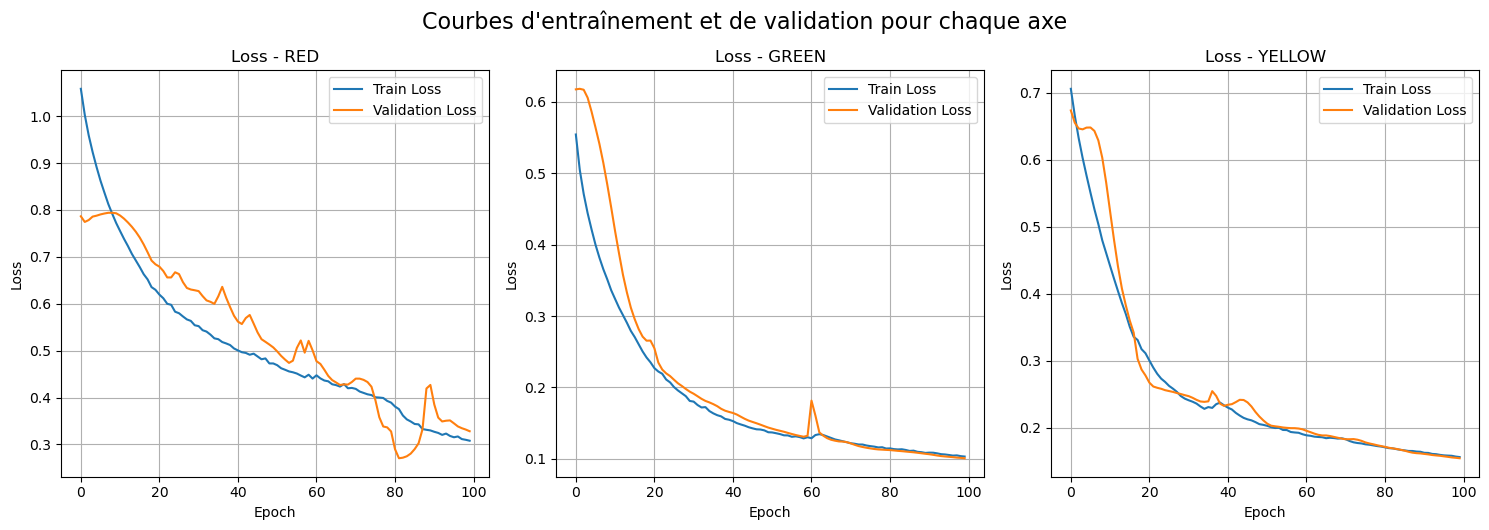

In [147]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

for i, axis in enumerate(['red', 'green', 'yellow']):
    plt.subplot(1, 3, i + 1)
    
    train_loss = train_losses_by_axis[axis]
    val_loss = valid_losses_by_axis[axis]

    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title(f"Loss - {axis.upper()}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.suptitle("Courbes d'entraînement et de validation pour chaque axe", fontsize=16, y=1.05)
plt.show()

---
## <span style="color:brown"> 5. Perform the inference on the test dataset


### <span style="color:brown"> 5.1 Load the weight of the best model
You could use other weights for your model...

In [148]:
from collections import OrderedDict

# === Paramètres du modèle ===
input_shape = (1, width, height)  # tu travailles en niveaux de gris
num_classes = 1
output_shape = (num_classes, width, height)
init_channels = 32

# === Dictionnaire pour stocker les modèles ===
models_by_axis = {}

for axis in ['red', 'green', 'yellow']:
    print(f"Chargement du modèle pour l’axe : {axis.upper()}")
    
    # Initialiser un nouveau modèle
    model = UNet(input_shape=input_shape, output_shape=output_shape, init_channels=init_channels).to(device)
    
    # Charger les poids depuis le fichier
    weights_path = f"best_unet_{axis}.pth"
    state_dict = torch.load(weights_path, map_location=device)

    # Charger les poids dans le modèle
    model.load_state_dict(state_dict)
    model.eval()  # pour l'inférence (désactive dropout et batchnorm)
    
    # Stocker le modèle dans le dictionnaire
    models_by_axis[axis] = model

Chargement du modèle pour l’axe : RED
Chargement du modèle pour l’axe : GREEN
Chargement du modèle pour l’axe : YELLOW


Then, we perform the inference on a sample from the test dataset and plot the prediction.
Run the following cell many times to test several images.
**Take care of the dimensions of tensors and data !...**


### <span style="color:brown"> 5.2 Test and visualized the results on one sample of the test_dataset

We compare the computation of Dice and IoU metrics using two approaches:
1. **Custom Functions**: Defined directly in the code.
2. **MONAI Metrics**: Utilizing the built-in metrics provided by the MONAI library.

In [149]:
from torch.utils.data import DataLoader
import os

# Configuration
num_workers=0
print("num_workers =", num_workers)

# Création des test_dataloader par axe (batch=1 pour affichage)
test_dataloaders = {}
test_iterators = {}

for axis in ['red', 'green', 'yellow']:
    print(f"Création du test_dataloader pour l'axe {axis.upper()}")
    
    test_dataset = all_datasets[axis]['test']
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=5,
        pin_memory=torch.cuda.is_available(),
        shuffle=False,
        num_workers=num_workers
    )
    
    # Stocker le dataloader et son itérateur
    test_dataloaders[axis] = test_loader
    test_iterators[axis] = iter(test_loader)

for axis in ['red', 'green', 'yellow']:
    test_dataset = all_datasets[axis]['test']
    print(f"Axe {axis.upper()} – Nombre d’échantillons dans le test set : {len(test_dataset)}")



num_workers = 0
Création du test_dataloader pour l'axe RED
Création du test_dataloader pour l'axe GREEN
Création du test_dataloader pour l'axe YELLOW
Axe RED – Nombre d’échantillons dans le test set : 1
Axe GREEN – Nombre d’échantillons dans le test set : 1
Axe YELLOW – Nombre d’échantillons dans le test set : 1



Affichage de l’échantillon 0 du batch pour l'axe RED


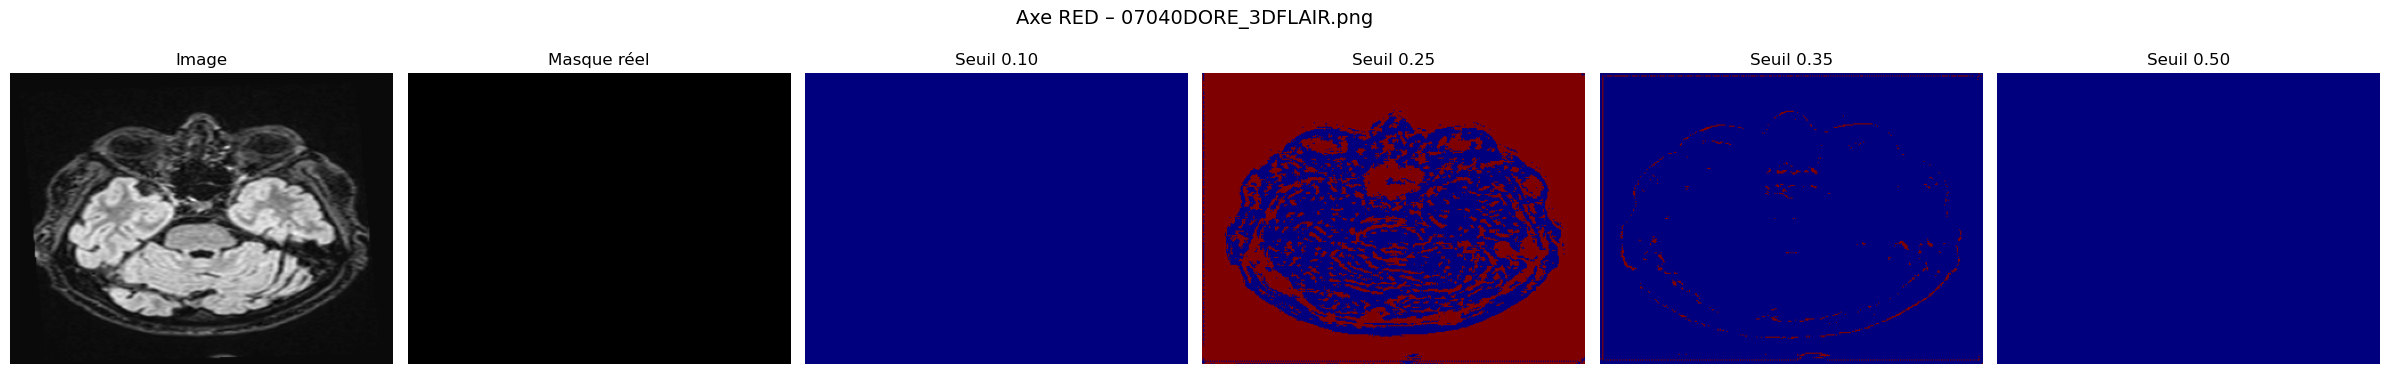


Affichage de l’échantillon 0 du batch pour l'axe GREEN


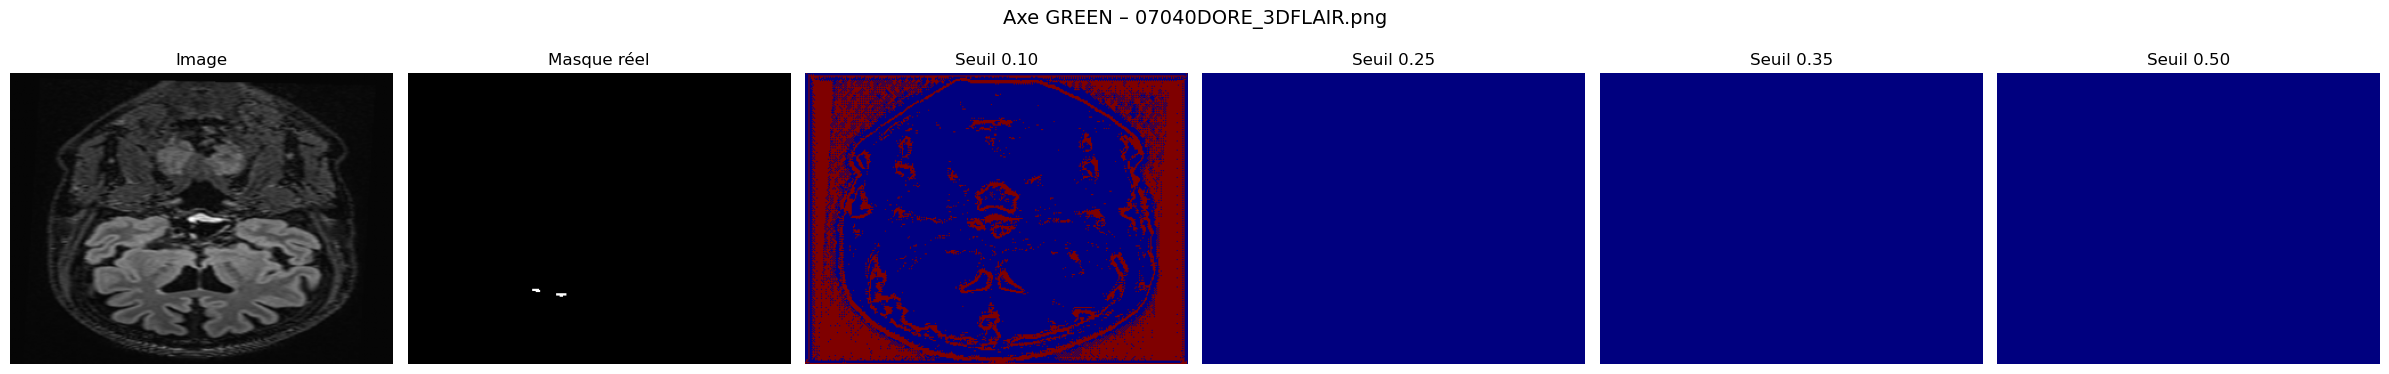


Affichage de l’échantillon 0 du batch pour l'axe YELLOW


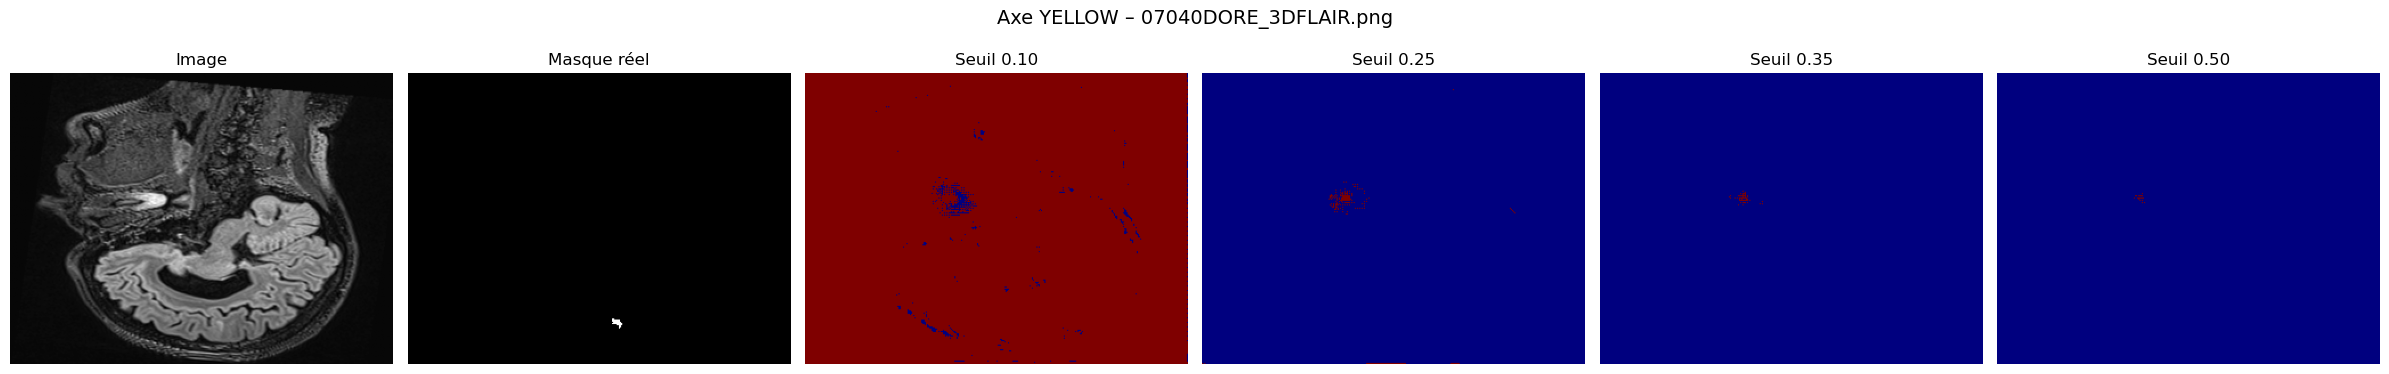

In [150]:
import matplotlib.pyplot as plt
import torch
import os

thresholds = [0.1, 0.25, 0.35, 0.5]
target_index = 0  # L’échantillon que tu veux afficher dans le batch

for axis in ['red', 'green', 'yellow']:
    print(f"\nAffichage de l’échantillon {target_index} du batch pour l'axe {axis.upper()}")

    model = models_by_axis[axis]
    model.eval()

    # Récupérer le premier batch (contenant au moins target_index)
    image_batch, label_batch, path_batch = next(iter(test_dataloaders[axis]))
    image_batch, label_batch = image_batch.to(device), label_batch.to(device)

    # Vérification que l’index demandé est bien dans le batch
    if target_index >= image_batch.shape[0]:
        print(f" Le batch pour l’axe {axis.upper()} ne contient que {image_batch.shape[0]} échantillons.")
        continue

    # Extraire l’échantillon ciblé
    image = image_batch[target_index:target_index+1]
    label = label_batch[target_index:target_index+1]
    path = path_batch[target_index]

    with torch.no_grad():
        pred = model(image)
        pred_sigmoid = torch.sigmoid(pred)

    n_cols = 2 + len(thresholds)
    plt.figure(figsize=(4 * n_cols, 4))
    plt.suptitle(f"Axe {axis.upper()} – {os.path.basename(path)}", fontsize=14)

    plt.subplot(1, n_cols, 1)
    plt.imshow(image[0, 0].cpu(), cmap='gray')
    plt.title("Image")
    plt.axis('off')

    plt.subplot(1, n_cols, 2)
    plt.imshow(label[0, 0].cpu(), cmap='gray')
    plt.title("Masque réel")
    plt.axis('off')

    for j, thresh in enumerate(thresholds):
        pred_bin = (pred_sigmoid > thresh).float()
        plt.subplot(1, n_cols, 3 + j)
        plt.imshow(pred_bin[0, 0].cpu(), cmap='jet')
        plt.title(f"Seuil {thresh:.2f}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


---
### <span style="color:brown"> 5.3 Computing Metrics on the Entire Test Dataset

In this section, we evaluate the segmentation accuracy across the entire test dataset.

Various metrics can be used for this purpose (refer to your lecture notes for details). You are encouraged to explore and implement additional metrics to test their performance.

### Metrics Used:
- **Dice Score**: Used here to measure segmentation accuracy.
- **IoU Metric**: Add your own user-defined implementation to compute IoU.
- **MONAI Metrics**: Experiment with MONAI's built-in metrics for comparison.
    (https://docs.monai.io/en/stable/metrics.html

In [151]:
# Custom functions
# Implementation 2: Dice Coefficient ( PyTorch version- Tensor operations)
def dice_coefficient(prediction, target, epsilon=1e-07):
    prediction_copy = prediction.clone()
    prediction_copy[prediction_copy < 0] = 0
    prediction_copy[prediction_copy > 0] = 1
    intersection = abs(torch.sum(prediction_copy * target))
    union = abs(torch.sum(prediction_copy) + torch.sum(target))
    dice = (2. * intersection + epsilon) / (union + epsilon)
    return dice

# Implementation 1: Dice Score (NumPy Version - Array operations)
def dice_score(pred, label):
    smooth = 1e-6
    intersection = np.sum(pred * label)
    return 2. * intersection / (np.sum(pred) + np.sum(label) + smooth)
    
#  IoU Score (Intersection over Union)  (NumPy Version - Array operations)
def iou_score(pred, label):
    return jaccard_score(label.flatten(), pred.flatten())

test_running_loss = 0
test_running_dc1 = 0
test_running_dc2 = 0  # comparison with dice_score function

model.eval()
with torch.no_grad():
    for idx, img_mask in enumerate(tqdm(test_dataloader, position=0, leave=True)):
        img = img_mask[0].float().to(device)
        mask = img_mask[1].float().to(device)
        if idx==0:
            print("0. img.shape:", img.shape,"0. mask.shape:",mask.shape)
        y_pred = model(img)
        loss = criterion(y_pred, mask)
        dc1 = dice_coefficient(y_pred, mask)
        
        y_pred = (torch.sigmoid(y_pred) > 0.3).float()
        np_mask = mask.squeeze(dim=0).squeeze(dim=0).detach().cpu().numpy()  # Same here
        np_y_pred = y_pred.squeeze(dim=0).squeeze(dim=0).detach().cpu().numpy()  # Sequentially remove the first two dimensions
        if idx==0:
            print("1.y_pred.shape:", y_pred.shape, "1. mask.shape:", mask.shape,"1. np_y_pred:", pred.shape)
        dc2 = dice_score(np_y_pred, np_mask)
       
        test_running_loss += loss.item()
        test_running_dc1 += dc1.item()
        test_running_dc2 += dc2.item()

    test_loss = test_running_loss / (idx + 1)
    test_dc1 = test_running_dc1 / (idx + 1)
    test_dc2 = test_running_dc2 / (idx + 1)

print(f"Final Dice Metric 1 : {test_dc1:.3f}")
print(f"Final Dice Metric 2  : {test_dc2:.3f}")
print(f"test Loss : {test_loss:.3f}")

""" Essai Dice et IoU de Monai à revoir, à ne pas effacer !!!!"""
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from monai.networks.nets import UNet
from sklearn.metrics import jaccard_score
from monai.metrics import  DiceMetric, MeanIoU

# Check the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Metrics initialisation
dice_metric = DiceMetric(include_background=True, reduction="mean")
iou_metric = MeanIoU(include_background=True)  # No num_classes argument

# Dice and IoU metrics from monai, reset before use
dice_metric.reset()
iou_metric.reset()




100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 50.25it/s]

0. img.shape: torch.Size([1, 1, 256, 336]) 0. mask.shape: torch.Size([1, 1, 256, 336])
1.y_pred.shape: torch.Size([1, 1, 256, 336]) 1. mask.shape: torch.Size([1, 1, 256, 336]) 1. np_y_pred: torch.Size([1, 1, 256, 336])
Final Dice Metric 1 : 0.000
Final Dice Metric 2  : 0.000
test Loss : 0.154


### 5.4 Hidden

In [153]:
!pip install medpy

import torch
import numpy as np
from tqdm import tqdm
from sklearn.metrics import jaccard_score
from monai.metrics import DiceMetric, MeanIoU
from medpy.metric.binary import hd95

def dice_score(pred, label):
    smooth = 1e-6
    if np.sum(label) == 0 and np.sum(pred) == 0:
        return 1.0  # Prédiction parfaite sur fond vide
    elif np.sum(label) == 0:
        return 0.0  # Faux positif
    intersection = np.sum(pred * label)
    return 2. * intersection / (np.sum(pred) + np.sum(label) + smooth)

def iou_score(pred, label):
    if np.sum(label) == 0 and np.sum(pred) == 0:
        return 1.0
    elif np.sum(label) == 0:
        return 0.0
    return jaccard_score(label.flatten(), pred.flatten())

def compute_hd95(pred, label):
    try:
        if np.sum(label) == 0 and np.sum(pred) == 0:
            return 0.0  # Parfait
        elif np.sum(label) == 0 or np.sum(pred) == 0:
            return np.nan  # Pas comparable
        return hd95(pred.astype(bool), label.astype(bool))
    except:
        return np.nan


thresholds = np.arange(0.2, 0.51, 0.05)
final_results = {}

for axis in ['red', 'green', 'yellow']:
    model = models_by_axis[axis]
    test_dataloader = test_dataloaders[axis]
    model.eval()
    results = {}

    with torch.no_grad():
        for threshold in thresholds:
            print(f"\n🔎 {axis.upper()} – Évaluation pour seuil {threshold:.2f}")
            dice_metric = DiceMetric(include_background=False, reduction="mean")
            iou_metric = MeanIoU(include_background=False)
            dice_metric.reset()
            iou_metric.reset()

            test_running_loss = 0
            test_running_dice = 0
            test_running_iou = 0
            test_running_hd95 = 0
            hd95_count = 0

            for idx, (img, mask, _) in enumerate(tqdm(test_dataloader, desc=f"{axis.upper()} - seuil {threshold:.2f}", leave=False)):
                img = img.float().to(device)
                mask = mask.float().to(device)

                output = model(img)
                loss = criterion(output, mask)

                y_pred = (torch.sigmoid(output) > threshold).float()
                dice_metric(y_pred, mask)
                iou_metric(y_pred, mask)

                np_mask = mask.cpu().numpy().squeeze(1)
                np_pred = y_pred.cpu().numpy().squeeze(1)

                for p, m in zip(np_pred, np_mask):
                    test_running_dice += dice_score(p, m)
                    test_running_iou += iou_score(p, m)
                    hd = compute_hd95(p, m)
                    if not np.isnan(hd):
                        test_running_hd95 += hd
                        hd95_count += 1

                test_running_loss += loss.item()

                print("👉 Stats prédiction brute et mask :")
                print("  max(pred):", fused_pred.max().item(), "min(pred):", fused_pred.min().item())
                print("  mask.sum():", label.sum().item())
                print("  pred.sum() après seuillage:", fused_bin.sum().item())


            n_samples = len(test_dataloader.dataset)
            avg_loss = test_running_loss / (idx + 1)
            avg_dice = test_running_dice / n_samples
            avg_iou = test_running_iou / n_samples
            avg_hd95 = test_running_hd95 / hd95_count if hd95_count > 0 else np.nan

            results[threshold] = {
                "loss": avg_loss,
                "dice_custom": avg_dice,
                "iou_custom": avg_iou,
                "dice_monai": dice_metric.aggregate().item(),
                "iou_monai": iou_metric.aggregate().item(),
                "hd95": avg_hd95
            }

    final_results[axis] = results

# Affichage des résultats
import pandas as pd
df = pd.concat({k: pd.DataFrame(v).T for k, v in final_results.items()})
df



🔎 RED – Évaluation pour seuil 0.20


👉 Stats prédiction brute et mask :
  max(pred): 0.5092065930366516 min(pred): 0.12048622965812683
  mask.sum(): 42.0
  pred.sum() après seuillage: 1.0

🔎 RED – Évaluation pour seuil 0.25


👉 Stats prédiction brute et mask :
  max(pred): 0.5092065930366516 min(pred): 0.12048622965812683
  mask.sum(): 42.0
  pred.sum() après seuillage: 1.0

🔎 RED – Évaluation pour seuil 0.30


👉 Stats prédiction brute et mask :
  max(pred): 0.5092065930366516 min(pred): 0.12048622965812683
  mask.sum(): 42.0
  pred.sum() après seuillage: 1.0

🔎 RED – Évaluation pour seuil 0.35


👉 Stats prédiction brute et mask :
  max(pred): 0.5092065930366516 min(pred): 0.12048622965812683
  mask.sum(): 42.0
  pred.sum() après seuillage: 1.0

🔎 RED – Évaluation pour seuil 0.40


👉 Stats prédiction brute et mask :
  max(pred): 0.5092065930366516 min(pred): 0.12048622965812683
  mask.sum(): 42.0
  pred.sum() après seuillage: 1.0

🔎 RED – Évaluation pour seuil 0.45


👉 Stats prédiction brute et mask :
  max(pred): 0.5092065930366516 min(pred): 0.12048622965812683
  mask.sum(): 42.0
  pred.sum() après seuillage: 1.0



🔎 RED – Évaluation pour seuil 0.50


👉 Stats prédiction brute et mask :
  max(pred): 0.5092065930366516 min(pred): 0.12048622965812683
  mask.sum(): 42.0
  pred.sum() après seuillage: 1.0

🔎 GREEN – Évaluation pour seuil 0.20


👉 Stats prédiction brute et mask :
  max(pred): 0.5092065930366516 min(pred): 0.12048622965812683
  mask.sum(): 42.0
  pred.sum() après seuillage: 1.0

🔎 GREEN – Évaluation pour seuil 0.25


GREEN - seuil 0.25:   0%|                                                                        | 0/1 [00:00<?, ?it/s]

👉 Stats prédiction brute et mask :


  max(pred): 0.5092065930366516 min(pred): 0.12048622965812683
  mask.sum(): 42.0
  pred.sum() après seuillage: 1.0

🔎 GREEN – Évaluation pour seuil 0.30


👉 Stats prédiction brute et mask :
  max(pred): 0.5092065930366516 min(pred): 0.12048622965812683
  mask.sum(): 42.0
  pred.sum() après seuillage: 1.0

🔎 GREEN – Évaluation pour seuil 0.35


👉 Stats prédiction brute et mask :
  max(pred): 0.5092065930366516 min(pred): 0.12048622965812683
  mask.sum(): 42.0
  pred.sum() après seuillage: 1.0

🔎 GREEN – Évaluation pour seuil 0.40


GREEN - seuil 0.40:   0%|                                                                        | 0/1 [00:00<?, ?it/s]

👉 Stats prédiction brute et mask :


  max(pred): 0.5092065930366516 min(pred): 0.12048622965812683
  mask.sum(): 42.0
  pred.sum() après seuillage: 1.0

🔎 GREEN – Évaluation pour seuil 0.45


GREEN - seuil 0.45:   0%|                                                                        | 0/1 [00:00<?, ?it/s]

👉 Stats prédiction brute et mask :


  max(pred): 0.5092065930366516 min(pred): 0.12048622965812683
  mask.sum(): 42.0
  pred.sum() après seuillage: 1.0

🔎 GREEN – Évaluation pour seuil 0.50


👉 Stats prédiction brute et mask :
  max(pred): 0.5092065930366516 min(pred): 0.12048622965812683
  mask.sum(): 42.0
  pred.sum() après seuillage: 1.0

🔎 YELLOW – Évaluation pour seuil 0.20


YELLOW - seuil 0.20:   0%|                                                                       | 0/1 [00:00<?, ?it/s]

👉 Stats prédiction brute et mask :


  max(pred): 0.5092065930366516 min(pred): 0.12048622965812683
  mask.sum(): 42.0
  pred.sum() après seuillage: 1.0

🔎 YELLOW – Évaluation pour seuil 0.25


👉 Stats prédiction brute et mask :
  max(pred): 0.5092065930366516 min(pred): 0.12048622965812683
  mask.sum(): 42.0
  pred.sum() après seuillage: 1.0

🔎 YELLOW – Évaluation pour seuil 0.30


YELLOW - seuil 0.30:   0%|                                                                       | 0/1 [00:00<?, ?it/s]

👉 Stats prédiction brute et mask :


  max(pred): 0.5092065930366516 min(pred): 0.12048622965812683
  mask.sum(): 42.0
  pred.sum() après seuillage: 1.0

🔎 YELLOW – Évaluation pour seuil 0.35


👉 Stats prédiction brute et mask :
  max(pred): 0.5092065930366516 min(pred): 0.12048622965812683
  mask.sum(): 42.0
  pred.sum() après seuillage: 1.0

🔎 YELLOW – Évaluation pour seuil 0.40


YELLOW - seuil 0.40:   0%|                                                                       | 0/1 [00:00<?, ?it/s]

👉 Stats prédiction brute et mask :


  max(pred): 0.5092065930366516 min(pred): 0.12048622965812683
  mask.sum(): 42.0
  pred.sum() après seuillage: 1.0

🔎 YELLOW – Évaluation pour seuil 0.45


👉 Stats prédiction brute et mask :
  max(pred): 0.5092065930366516 min(pred): 0.12048622965812683
  mask.sum(): 42.0
  pred.sum() après seuillage: 1.0

🔎 YELLOW – Évaluation pour seuil 0.50


👉 Stats prédiction brute et mask :
  max(pred): 0.5092065930366516 min(pred): 0.12048622965812683
  mask.sum(): 42.0
  pred.sum() après seuillage: 1.0


loss  dice_custom  iou_custom  dice_monai  iou_monai  \
red    0.20  0.321975          0.0         0.0         0.0        0.0   
       0.25  0.321975          0.0         0.0         0.0        0.0   
       0.30  0.321975          0.0         0.0         0.0        0.0   
       0.35  0.321975          0.0         0.0         0.0        0.0   
       0.40  0.321975          0.0         0.0         0.0        0.0   
       0.45  0.321975          0.0         0.0         0.0        0.0   
       0.50  0.321975          1.0         1.0         0.0        0.0   
green  0.20  0.098529          0.0         0.0         0.0        0.0   
       0.25  0.098529          0.0         0.0         0.0        0.0   
       0.30  0.098529          0.0         0.0         0.0        0.0   
       0.35  0.098529          0.0         0.0         0.0        0.0   
       0.40  0.098529          0.0         0.0         0.0        0.0   
       0.45  0.098529          0.0         0.0         0.0        0.0   
       0.50  0.098529          0.0         0.0         0.0        0.0   
yellow 0.20  0.153640          0.0         0.0         0.0        0.0   
       0.25  0.153640          0.0         0.0         0.0        0.0   
       0.30  0.153640          0.0         0.0         0.0        0.0   
       0.35  0.153640          0.0         0.0         0.0        0.0   
       0.40  0.153640          0.0         0.0         0.0        0.0   
       0.45  0.153640          0.0         0.0         0.0        0.0   
       0.50  0.153640          0.0         0.0         0.0        0.0   

                   hd95  
red    0.20         NaN  
       0.25         NaN  
       0.30         NaN  
       0.35         NaN  
       0.40         NaN  
       0.45         NaN  
       0.50    0.000000  
green  0.20  110.937845  
       0.25         NaN  
       0.30         NaN  
       0.35         NaN  
       0.40         NaN  
       0.45         NaN  
       0.50         NaN  
yellow 0.20  211.529651  
       0.25  127.937916  
       0.30  125.399362  
       0.35  123.569801  
       0.40  122.578342  
       0.45  122.564063  
       0.50  122.582012

In [154]:
!pip install -q medpy
import torch
import numpy as np
from tqdm import tqdm
from sklearn.metrics import jaccard_score
from monai.metrics import DiceMetric, MeanIoU
from medpy.metric.binary import hd95

# --- Fonctions robustes personnalisées ---
def dice_score(pred, label):
    smooth = 1e-6
    if np.sum(label) == 0 and np.sum(pred) == 0:
        return 1.0  # Cas parfait : rien à prédire et rien prédit
    elif np.sum(label) == 0:
        return 0.0  # Faux positifs
    intersection = np.sum(pred * label)
    return 2. * intersection / (np.sum(pred) + np.sum(label) + smooth)

def iou_score(pred, label):
    if np.sum(label) == 0 and np.sum(pred) == 0:
        return 1.0
    elif np.sum(label) == 0:
        return 0.0
    return jaccard_score(label.flatten(), pred.flatten())

def compute_hd95(pred, label):
    try:
        if np.sum(label) == 0 and np.sum(pred) == 0:
            return 0.0
        elif np.sum(label) == 0 or np.sum(pred) == 0:
            return np.nan
        return hd95(pred.astype(bool), label.astype(bool))
    except:
        return np.nan

# --- Paramètres ---
thresholds = np.arange(0.2, 0.51, 0.05)
results_fusion = {}

print("📊 Fusion des axes et évaluation multi-seuils")

for threshold in thresholds:
    print(f"\nÉvaluation fusionnée - Seuil = {threshold:.2f}")
    
    dice_metric = DiceMetric(include_background=False, reduction="mean")
    iou_metric = MeanIoU(include_background=False)
    dice_metric.reset()
    iou_metric.reset()

    fusion_dice = 0
    fusion_iou = 0
    fusion_hd95 = 0
    count_hd = 0
    sample_count = 0

    for i, (data_r, data_g, data_y) in enumerate(zip(
        test_dataloaders["red"], test_dataloaders["green"], test_dataloaders["yellow"]
    )):
        # Chargement des données
        img_r, mask_r = data_r[0].to(device), data_r[1].to(device)
        img_g, mask_g = data_g[0].to(device), data_g[1].to(device)
        img_y, mask_y = data_y[0].to(device), data_y[1].to(device)

        label = mask_r  # masque commun supposé

        # Prédictions
        with torch.no_grad():
            out_r = torch.sigmoid(models_by_axis["red"](img_r))
            out_g = torch.sigmoid(models_by_axis["green"](img_g))
            out_y = torch.sigmoid(models_by_axis["yellow"](img_y))

        # Fusion voxel-wise (max)
        fused_pred = torch.max(torch.max(out_r, out_g), out_y)
        fused_bin = (fused_pred > threshold).float()

        # MONAI metrics
        dice_metric(fused_bin, label)
        iou_metric(fused_bin, label)

        # Conversion pour métriques custom
        pred_np = fused_bin.cpu().numpy().squeeze()
        label_np = label.cpu().numpy().squeeze()

        fusion_dice += dice_score(pred_np, label_np)
        fusion_iou += iou_score(pred_np, label_np)

        hd = compute_hd95(pred_np, label_np)
        if not np.isnan(hd):
            fusion_hd95 += hd
            count_hd += 1

        sample_count += 1

    results_fusion[threshold] = {
        "dice_custom": fusion_dice / sample_count,
        "iou_custom": fusion_iou / sample_count,
        "dice_monai": dice_metric.aggregate().item(),
        "iou_monai": iou_metric.aggregate().item(),
        "hd95": fusion_hd95 / count_hd if count_hd > 0 else np.nan
    }

# --- Affichage des résultats ---
print("\n📊 Résultats FUSION :")
for t, metrics in results_fusion.items():
    print(f"\nSeuil = {t:.2f}")
    print(f"  Dice (custom)  : {metrics['dice_custom']:.4f}")
    print(f"  IoU  (custom)  : {metrics['iou_custom']:.4f}")
    print(f"  Dice (MONAI)   : {metrics['dice_monai']:.4f}")
    print(f"  IoU  (MONAI)   : {metrics['iou_monai']:.4f}")
    print(f"  HD95 (MedPy)   : {metrics['hd95']:.2f}")


📊 Fusion des axes et évaluation multi-seuils

Évaluation fusionnée - Seuil = 0.20

Évaluation fusionnée - Seuil = 0.25

Évaluation fusionnée - Seuil = 0.30

Évaluation fusionnée - Seuil = 0.35

Évaluation fusionnée - Seuil = 0.40

Évaluation fusionnée - Seuil = 0.45

Évaluation fusionnée - Seuil = 0.50

📊 Résultats FUSION :

Seuil = 0.20
  Dice (custom)  : 0.0000
  IoU  (custom)  : 0.0000
  Dice (MONAI)   : 0.0000
  IoU  (MONAI)   : 0.0000
  HD95 (MedPy)   : nan

Seuil = 0.25
  Dice (custom)  : 0.0000
  IoU  (custom)  : 0.0000
  Dice (MONAI)   : 0.0000
  IoU  (MONAI)   : 0.0000
  HD95 (MedPy)   : nan

Seuil = 0.30
  Dice (custom)  : 0.0000
  IoU  (custom)  : 0.0000
  Dice (MONAI)   : 0.0000
  IoU  (MONAI)   : 0.0000
  HD95 (MedPy)   : nan

Seuil = 0.35
  Dice (custom)  : 0.0000
  IoU  (custom)  : 0.0000
  Dice (MONAI)   : 0.0000
  IoU  (MONAI)   : 0.0000
  HD95 (MedPy)   : nan

Seuil = 0.40
  Dice (custom)  : 0.0000
  IoU  (custom)  : 0.0000
  Dice (MONAI)   : 0.0000
  IoU  (MONAI)   :

In [ ]:
# Toolkit function
# Windows may create an hidden file "Thumbs.db". If the error occurs, run the following funtion
def delete_thumbs_db(directory):
    # Parcours de tous les fichiers et sous-dossiers du répertoire
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file == "Thumbs.db":
                file_path = os.path.join(root, file)
                try:
                    os.remove(file_path)
                    print(f"Supprimé : {file_path}")
                except Exception as e:
                    print(f"Erreur lors de la suppression de {file_path} : {e}")

# Remplacez 'chemin/vers/dossier' par le chemin réel de votre répertoire
delete_thumbs_db("data/carvana/train")
delete_thumbs_db("data/carvana/train_masks")